In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 9:33 - loss: 2.4207 - STD: 0.1295 - MAE: 0.2178

  5/395 [..............................] - ETA: 6s - loss: 2.1573 - STD: 0.0661 - MAE: 0.2165  

  8/395 [..............................] - ETA: 6s - loss: 2.1335 - STD: 0.0561 - MAE: 0.2167

 11/395 [..............................] - ETA: 6s - loss: 2.1227 - STD: 0.0535 - MAE: 0.2167

 14/395 [>.............................] - ETA: 6s - loss: 2.1110 - STD: 0.0514 - MAE: 0.2166

 17/395 [>.............................] - ETA: 6s - loss: 2.1004 - STD: 0.0482 - MAE: 0.2166

 20/395 [>.............................] - ETA: 6s - loss: 2.0930 - STD: 0.0455 - MAE: 0.2166

 23/395 [>.............................] - ETA: 6s - loss: 2.0882 - STD: 0.0441 - MAE: 0.2166

 26/395 [>.............................] - ETA: 6s - loss: 2.0839 - STD: 0.0431 - MAE: 0.2166

 29/395 [=>............................] - ETA: 6s - loss: 2.0791 - STD: 0.0420 - MAE: 0.2165

 32/395 [=>............................] - ETA: 6s - loss: 2.0747 - STD: 0.0411 - MAE: 0.2165

 35/395 [=>............................] - ETA: 6s - loss: 2.0704 - STD: 0.0405 - MAE: 0.2164

 38/395 [=>............................] - ETA: 6s - loss: 2.0658 - STD: 0.0402 - MAE: 0.2163

 41/395 [==>...........................] - ETA: 6s - loss: 2.0601 - STD: 0.0402 - MAE: 0.2161

 44/395 [==>...........................] - ETA: 6s - loss: 2.0534 - STD: 0.0405 - MAE: 0.2159

 47/395 [==>...........................] - ETA: 6s - loss: 2.0460 - STD: 0.0413 - MAE: 0.2156

 50/395 [==>...........................] - ETA: 6s - loss: 2.0382 - STD: 0.0425 - MAE: 0.2152

 53/395 [===>..........................] - ETA: 6s - loss: 2.0298 - STD: 0.0438 - MAE: 0.2148

 56/395 [===>..........................] - ETA: 5s - loss: 2.0208 - STD: 0.0452 - MAE: 0.2144

 59/395 [===>..........................] - ETA: 5s - loss: 2.0121 - STD: 0.0467 - MAE: 0.2140

 62/395 [===>..........................] - ETA: 5s - loss: 2.0033 - STD: 0.0481 - MAE: 0.2135

 65/395 [===>..........................] - ETA: 5s - loss: 1.9944 - STD: 0.0496 - MAE: 0.2131

 68/395 [====>.........................] - ETA: 5s - loss: 1.9852 - STD: 0.0510 - MAE: 0.2126

 71/395 [====>.........................] - ETA: 5s - loss: 1.9760 - STD: 0.0524 - MAE: 0.2121

 74/395 [====>.........................] - ETA: 5s - loss: 1.9667 - STD: 0.0537 - MAE: 0.2117

 78/395 [====>.........................] - ETA: 5s - loss: 1.9529 - STD: 0.0556 - MAE: 0.2110

 81/395 [=====>........................] - ETA: 5s - loss: 1.9415 - STD: 0.0571 - MAE: 0.2104

 84/395 [=====>........................] - ETA: 5s - loss: 1.9296 - STD: 0.0586 - MAE: 0.2098

 87/395 [=====>........................] - ETA: 5s - loss: 1.9173 - STD: 0.0602 - MAE: 0.2092

 90/395 [=====>........................] - ETA: 5s - loss: 1.9044 - STD: 0.0620 - MAE: 0.2084

 93/395 [======>.......................] - ETA: 5s - loss: 1.8914 - STD: 0.0638 - MAE: 0.2077

 96/395 [======>.......................] - ETA: 5s - loss: 1.8785 - STD: 0.0656 - MAE: 0.2069

 99/395 [======>.......................] - ETA: 5s - loss: 1.8654 - STD: 0.0675 - MAE: 0.2061

102/395 [======>.......................] - ETA: 5s - loss: 1.8526 - STD: 0.0694 - MAE: 0.2053

105/395 [======>.......................] - ETA: 5s - loss: 1.8402 - STD: 0.0713 - MAE: 0.2045

108/395 [=======>......................] - ETA: 5s - loss: 1.8281 - STD: 0.0732 - MAE: 0.2037

111/395 [=======>......................] - ETA: 4s - loss: 1.8161 - STD: 0.0750 - MAE: 0.2029

114/395 [=======>......................] - ETA: 4s - loss: 1.8047 - STD: 0.0768 - MAE: 0.2022

117/395 [=======>......................] - ETA: 4s - loss: 1.7937 - STD: 0.0786 - MAE: 0.2014

120/395 [========>.....................] - ETA: 4s - loss: 1.7829 - STD: 0.0803 - MAE: 0.2007

123/395 [========>.....................] - ETA: 4s - loss: 1.7726 - STD: 0.0820 - MAE: 0.1999

126/395 [========>.....................] - ETA: 4s - loss: 1.7624 - STD: 0.0837 - MAE: 0.1992

129/395 [========>.....................] - ETA: 4s - loss: 1.7526 - STD: 0.0853 - MAE: 0.1985

132/395 [=========>....................] - ETA: 4s - loss: 1.7431 - STD: 0.0868 - MAE: 0.1978

135/395 [=========>....................] - ETA: 4s - loss: 1.7340 - STD: 0.0883 - MAE: 0.1971

138/395 [=========>....................] - ETA: 4s - loss: 1.7249 - STD: 0.0898 - MAE: 0.1965

141/395 [=========>....................] - ETA: 4s - loss: 1.7162 - STD: 0.0912 - MAE: 0.1958

144/395 [=========>....................] - ETA: 4s - loss: 1.7077 - STD: 0.0927 - MAE: 0.1952

147/395 [==========>...................] - ETA: 4s - loss: 1.6995 - STD: 0.0940 - MAE: 0.1946

150/395 [==========>...................] - ETA: 4s - loss: 1.6914 - STD: 0.0953 - MAE: 0.1940

153/395 [==========>...................] - ETA: 4s - loss: 1.6835 - STD: 0.0967 - MAE: 0.1934

156/395 [==========>...................] - ETA: 4s - loss: 1.6759 - STD: 0.0979 - MAE: 0.1928

159/395 [===========>..................] - ETA: 4s - loss: 1.6684 - STD: 0.0992 - MAE: 0.1922

162/395 [===========>..................] - ETA: 4s - loss: 1.6612 - STD: 0.1004 - MAE: 0.1917

165/395 [===========>..................] - ETA: 4s - loss: 1.6540 - STD: 0.1015 - MAE: 0.1911

166/395 [===========>..................] - ETA: 5s - loss: 1.6530 - STD: 0.1019 - MAE: 0.1909

169/395 [===========>..................] - ETA: 4s - loss: 1.6463 - STD: 0.1031 - MAE: 0.1904

172/395 [============>.................] - ETA: 4s - loss: 1.6400 - STD: 0.1042 - MAE: 0.1899

175/395 [============>.................] - ETA: 4s - loss: 1.6335 - STD: 0.1053 - MAE: 0.1894

178/395 [============>.................] - ETA: 4s - loss: 1.6272 - STD: 0.1063 - MAE: 0.1889

181/395 [============>.................] - ETA: 4s - loss: 1.6210 - STD: 0.1074 - MAE: 0.1884

184/395 [============>.................] - ETA: 4s - loss: 1.6151 - STD: 0.1084 - MAE: 0.1879

187/395 [=============>................] - ETA: 4s - loss: 1.6093 - STD: 0.1094 - MAE: 0.1875

190/395 [=============>................] - ETA: 4s - loss: 1.6035 - STD: 0.1103 - MAE: 0.1870

193/395 [=============>................] - ETA: 4s - loss: 1.5977 - STD: 0.1113 - MAE: 0.1866

196/395 [=============>................] - ETA: 4s - loss: 1.5922 - STD: 0.1122 - MAE: 0.1861

199/395 [==============>...............] - ETA: 4s - loss: 1.5868 - STD: 0.1131 - MAE: 0.1857

202/395 [==============>...............] - ETA: 4s - loss: 1.5815 - STD: 0.1140 - MAE: 0.1853

205/395 [==============>...............] - ETA: 4s - loss: 1.5763 - STD: 0.1148 - MAE: 0.1849

208/395 [==============>...............] - ETA: 3s - loss: 1.5710 - STD: 0.1157 - MAE: 0.1844

211/395 [===============>..............] - ETA: 3s - loss: 1.5660 - STD: 0.1165 - MAE: 0.1840

214/395 [===============>..............] - ETA: 3s - loss: 1.5611 - STD: 0.1173 - MAE: 0.1836

217/395 [===============>..............] - ETA: 3s - loss: 1.5562 - STD: 0.1181 - MAE: 0.1832

220/395 [===============>..............] - ETA: 3s - loss: 1.5516 - STD: 0.1189 - MAE: 0.1829

223/395 [===============>..............] - ETA: 3s - loss: 1.5468 - STD: 0.1197 - MAE: 0.1825

226/395 [================>.............] - ETA: 3s - loss: 1.5425 - STD: 0.1204 - MAE: 0.1821

229/395 [================>.............] - ETA: 3s - loss: 1.5383 - STD: 0.1212 - MAE: 0.1818

232/395 [================>.............] - ETA: 3s - loss: 1.5340 - STD: 0.1219 - MAE: 0.1814

235/395 [================>.............] - ETA: 3s - loss: 1.5297 - STD: 0.1226 - MAE: 0.1811

238/395 [=================>............] - ETA: 3s - loss: 1.5256 - STD: 0.1233 - MAE: 0.1807

241/395 [=================>............] - ETA: 3s - loss: 1.5217 - STD: 0.1240 - MAE: 0.1804

244/395 [=================>............] - ETA: 3s - loss: 1.5176 - STD: 0.1246 - MAE: 0.1801

247/395 [=================>............] - ETA: 3s - loss: 1.5136 - STD: 0.1253 - MAE: 0.1797

250/395 [=================>............] - ETA: 2s - loss: 1.5097 - STD: 0.1259 - MAE: 0.1794

253/395 [==================>...........] - ETA: 2s - loss: 1.5058 - STD: 0.1266 - MAE: 0.1791

257/395 [==================>...........] - ETA: 2s - loss: 1.5008 - STD: 0.1274 - MAE: 0.1787

260/395 [==================>...........] - ETA: 2s - loss: 1.4971 - STD: 0.1280 - MAE: 0.1784

263/395 [==================>...........] - ETA: 2s - loss: 1.4935 - STD: 0.1286 - MAE: 0.1781

266/395 [===================>..........] - ETA: 2s - loss: 1.4898 - STD: 0.1292 - MAE: 0.1778

269/395 [===================>..........] - ETA: 2s - loss: 1.4864 - STD: 0.1297 - MAE: 0.1775

272/395 [===================>..........] - ETA: 2s - loss: 1.4830 - STD: 0.1303 - MAE: 0.1772

275/395 [===================>..........] - ETA: 2s - loss: 1.4796 - STD: 0.1309 - MAE: 0.1769

278/395 [====================>.........] - ETA: 2s - loss: 1.4762 - STD: 0.1314 - MAE: 0.1766

281/395 [====================>.........] - ETA: 2s - loss: 1.4729 - STD: 0.1320 - MAE: 0.1763

284/395 [====================>.........] - ETA: 2s - loss: 1.4697 - STD: 0.1325 - MAE: 0.1761

287/395 [====================>.........] - ETA: 2s - loss: 1.4667 - STD: 0.1331 - MAE: 0.1758

290/395 [=====================>........] - ETA: 2s - loss: 1.4636 - STD: 0.1336 - MAE: 0.1755

293/395 [=====================>........] - ETA: 2s - loss: 1.4604 - STD: 0.1341 - MAE: 0.1753

296/395 [=====================>........] - ETA: 1s - loss: 1.4573 - STD: 0.1346 - MAE: 0.1750

299/395 [=====================>........] - ETA: 1s - loss: 1.4542 - STD: 0.1351 - MAE: 0.1747

302/395 [=====================>........] - ETA: 1s - loss: 1.4511 - STD: 0.1356 - MAE: 0.1745

305/395 [======================>.......] - ETA: 1s - loss: 1.4481 - STD: 0.1361 - MAE: 0.1742

308/395 [======================>.......] - ETA: 1s - loss: 1.4451 - STD: 0.1365 - MAE: 0.1740

311/395 [======================>.......] - ETA: 1s - loss: 1.4422 - STD: 0.1370 - MAE: 0.1737

314/395 [======================>.......] - ETA: 1s - loss: 1.4392 - STD: 0.1375 - MAE: 0.1735

318/395 [=======================>......] - ETA: 1s - loss: 1.4355 - STD: 0.1381 - MAE: 0.1731

321/395 [=======================>......] - ETA: 1s - loss: 1.4329 - STD: 0.1385 - MAE: 0.1729

324/395 [=======================>......] - ETA: 1s - loss: 1.4301 - STD: 0.1390 - MAE: 0.1727

327/395 [=======================>......] - ETA: 1s - loss: 1.4274 - STD: 0.1394 - MAE: 0.1724

330/395 [========================>.....] - ETA: 1s - loss: 1.4248 - STD: 0.1399 - MAE: 0.1722

333/395 [========================>.....] - ETA: 1s - loss: 1.4221 - STD: 0.1403 - MAE: 0.1720

336/395 [========================>.....] - ETA: 1s - loss: 1.4195 - STD: 0.1407 - MAE: 0.1717

339/395 [========================>.....] - ETA: 1s - loss: 1.4169 - STD: 0.1412 - MAE: 0.1715

342/395 [========================>.....] - ETA: 1s - loss: 1.4143 - STD: 0.1416 - MAE: 0.1713

345/395 [=========================>....] - ETA: 0s - loss: 1.4119 - STD: 0.1420 - MAE: 0.1711

348/395 [=========================>....] - ETA: 0s - loss: 1.4095 - STD: 0.1424 - MAE: 0.1709

352/395 [=========================>....] - ETA: 0s - loss: 1.4062 - STD: 0.1429 - MAE: 0.1706

355/395 [=========================>....] - ETA: 0s - loss: 1.4038 - STD: 0.1433 - MAE: 0.1704

358/395 [==========================>...] - ETA: 0s - loss: 1.4014 - STD: 0.1437 - MAE: 0.1701

361/395 [==========================>...] - ETA: 0s - loss: 1.3991 - STD: 0.1441 - MAE: 0.1699

364/395 [==========================>...] - ETA: 0s - loss: 1.3968 - STD: 0.1445 - MAE: 0.1697

367/395 [==========================>...] - ETA: 0s - loss: 1.3945 - STD: 0.1448 - MAE: 0.1695

370/395 [===========================>..] - ETA: 0s - loss: 1.3923 - STD: 0.1452 - MAE: 0.1693

373/395 [===========================>..] - ETA: 0s - loss: 1.3901 - STD: 0.1456 - MAE: 0.1691

376/395 [===========================>..] - ETA: 0s - loss: 1.3879 - STD: 0.1459 - MAE: 0.1689

379/395 [===========================>..] - ETA: 0s - loss: 1.3857 - STD: 0.1463 - MAE: 0.1688

382/395 [============================>.] - ETA: 0s - loss: 1.3837 - STD: 0.1466 - MAE: 0.1686

385/395 [============================>.] - ETA: 0s - loss: 1.3815 - STD: 0.1470 - MAE: 0.1684

388/395 [============================>.] - ETA: 0s - loss: 1.3794 - STD: 0.1473 - MAE: 0.1682

391/395 [============================>.] - ETA: 0s - loss: 1.3773 - STD: 0.1477 - MAE: 0.1680

394/395 [============================>.] - ETA: 0s - loss: 1.3752 - STD: 0.1480 - MAE: 0.1678

395/395 [==============================] - 10s 23ms/step - loss: 1.3746 - STD: 0.1481 - MAE: 0.1678 - val_loss: 1.1823 - val_STD: 0.1906 - val_MAE: 0.1453


Epoch 2/10000


  1/395 [..............................] - ETA: 22s - loss: 1.1056 - STD: 0.1916 - MAE: 0.1439

  4/395 [..............................] - ETA: 7s - loss: 1.1197 - STD: 0.1920 - MAE: 0.1444 

  7/395 [..............................] - ETA: 7s - loss: 1.1266 - STD: 0.1921 - MAE: 0.1446

 10/395 [..............................] - ETA: 7s - loss: 1.1198 - STD: 0.1921 - MAE: 0.1443

 13/395 [..............................] - ETA: 6s - loss: 1.1152 - STD: 0.1921 - MAE: 0.1441

 16/395 [>.............................] - ETA: 7s - loss: 1.1137 - STD: 0.1923 - MAE: 0.1440

 19/395 [>.............................] - ETA: 6s - loss: 1.1123 - STD: 0.1924 - MAE: 0.1439

 22/395 [>.............................] - ETA: 6s - loss: 1.1114 - STD: 0.1923 - MAE: 0.1438

 25/395 [>.............................] - ETA: 6s - loss: 1.1098 - STD: 0.1923 - MAE: 0.1438

 28/395 [=>............................] - ETA: 6s - loss: 1.1083 - STD: 0.1924 - MAE: 0.1437

 31/395 [=>............................] - ETA: 6s - loss: 1.1068 - STD: 0.1925 - MAE: 0.1435

 34/395 [=>............................] - ETA: 6s - loss: 1.1059 - STD: 0.1925 - MAE: 0.1435

 37/395 [=>............................] - ETA: 6s - loss: 1.1050 - STD: 0.1925 - MAE: 0.1434

 41/395 [==>...........................] - ETA: 6s - loss: 1.1042 - STD: 0.1927 - MAE: 0.1433

 44/395 [==>...........................] - ETA: 6s - loss: 1.1027 - STD: 0.1929 - MAE: 0.1432

 47/395 [==>...........................] - ETA: 6s - loss: 1.1018 - STD: 0.1930 - MAE: 0.1430

 51/395 [==>...........................] - ETA: 6s - loss: 1.1001 - STD: 0.1931 - MAE: 0.1429

 54/395 [===>..........................] - ETA: 6s - loss: 1.1003 - STD: 0.1931 - MAE: 0.1429

 57/395 [===>..........................] - ETA: 6s - loss: 1.0995 - STD: 0.1932 - MAE: 0.1428

 60/395 [===>..........................] - ETA: 5s - loss: 1.0991 - STD: 0.1933 - MAE: 0.1428

 64/395 [===>..........................] - ETA: 5s - loss: 1.0982 - STD: 0.1934 - MAE: 0.1427

 67/395 [====>.........................] - ETA: 5s - loss: 1.0972 - STD: 0.1935 - MAE: 0.1426

 70/395 [====>.........................] - ETA: 5s - loss: 1.0969 - STD: 0.1936 - MAE: 0.1426

 73/395 [====>.........................] - ETA: 5s - loss: 1.0960 - STD: 0.1936 - MAE: 0.1425

 76/395 [====>.........................] - ETA: 5s - loss: 1.0958 - STD: 0.1937 - MAE: 0.1425

 79/395 [=====>........................] - ETA: 5s - loss: 1.0948 - STD: 0.1938 - MAE: 0.1424

 82/395 [=====>........................] - ETA: 5s - loss: 1.0942 - STD: 0.1939 - MAE: 0.1423

 85/395 [=====>........................] - ETA: 5s - loss: 1.0933 - STD: 0.1940 - MAE: 0.1422

 88/395 [=====>........................] - ETA: 5s - loss: 1.0929 - STD: 0.1940 - MAE: 0.1422

 91/395 [=====>........................] - ETA: 5s - loss: 1.0922 - STD: 0.1942 - MAE: 0.1421

 94/395 [======>.......................] - ETA: 5s - loss: 1.0919 - STD: 0.1942 - MAE: 0.1420

 97/395 [======>.......................] - ETA: 5s - loss: 1.0911 - STD: 0.1943 - MAE: 0.1420

100/395 [======>.......................] - ETA: 5s - loss: 1.0902 - STD: 0.1943 - MAE: 0.1419

103/395 [======>.......................] - ETA: 5s - loss: 1.0896 - STD: 0.1944 - MAE: 0.1418

106/395 [=======>......................] - ETA: 5s - loss: 1.0890 - STD: 0.1945 - MAE: 0.1418

109/395 [=======>......................] - ETA: 5s - loss: 1.0884 - STD: 0.1946 - MAE: 0.1417

112/395 [=======>......................] - ETA: 5s - loss: 1.0879 - STD: 0.1946 - MAE: 0.1417

115/395 [=======>......................] - ETA: 4s - loss: 1.0878 - STD: 0.1947 - MAE: 0.1416

118/395 [=======>......................] - ETA: 4s - loss: 1.0872 - STD: 0.1948 - MAE: 0.1416

121/395 [========>.....................] - ETA: 4s - loss: 1.0867 - STD: 0.1949 - MAE: 0.1415

124/395 [========>.....................] - ETA: 4s - loss: 1.0863 - STD: 0.1949 - MAE: 0.1414

127/395 [========>.....................] - ETA: 4s - loss: 1.0858 - STD: 0.1950 - MAE: 0.1414

130/395 [========>.....................] - ETA: 4s - loss: 1.0853 - STD: 0.1951 - MAE: 0.1414

133/395 [=========>....................] - ETA: 4s - loss: 1.0845 - STD: 0.1951 - MAE: 0.1413

136/395 [=========>....................] - ETA: 4s - loss: 1.0837 - STD: 0.1952 - MAE: 0.1412

139/395 [=========>....................] - ETA: 4s - loss: 1.0830 - STD: 0.1952 - MAE: 0.1411

142/395 [=========>....................] - ETA: 4s - loss: 1.0826 - STD: 0.1954 - MAE: 0.1411

145/395 [==========>...................] - ETA: 4s - loss: 1.0820 - STD: 0.1954 - MAE: 0.1410

148/395 [==========>...................] - ETA: 4s - loss: 1.0815 - STD: 0.1955 - MAE: 0.1410

151/395 [==========>...................] - ETA: 4s - loss: 1.0808 - STD: 0.1955 - MAE: 0.1409

154/395 [==========>...................] - ETA: 4s - loss: 1.0803 - STD: 0.1956 - MAE: 0.1409

157/395 [==========>...................] - ETA: 4s - loss: 1.0800 - STD: 0.1957 - MAE: 0.1408

160/395 [===========>..................] - ETA: 4s - loss: 1.0794 - STD: 0.1957 - MAE: 0.1408

163/395 [===========>..................] - ETA: 4s - loss: 1.0791 - STD: 0.1958 - MAE: 0.1407

166/395 [===========>..................] - ETA: 4s - loss: 1.0786 - STD: 0.1959 - MAE: 0.1407

169/395 [===========>..................] - ETA: 3s - loss: 1.0779 - STD: 0.1959 - MAE: 0.1406

172/395 [============>.................] - ETA: 3s - loss: 1.0775 - STD: 0.1960 - MAE: 0.1406

175/395 [============>.................] - ETA: 3s - loss: 1.0769 - STD: 0.1961 - MAE: 0.1405

178/395 [============>.................] - ETA: 3s - loss: 1.0765 - STD: 0.1962 - MAE: 0.1404

181/395 [============>.................] - ETA: 3s - loss: 1.0760 - STD: 0.1962 - MAE: 0.1404

184/395 [============>.................] - ETA: 3s - loss: 1.0756 - STD: 0.1963 - MAE: 0.1403

187/395 [=============>................] - ETA: 3s - loss: 1.0751 - STD: 0.1963 - MAE: 0.1403

190/395 [=============>................] - ETA: 3s - loss: 1.0745 - STD: 0.1964 - MAE: 0.1402

193/395 [=============>................] - ETA: 3s - loss: 1.0739 - STD: 0.1965 - MAE: 0.1402

196/395 [=============>................] - ETA: 3s - loss: 1.0734 - STD: 0.1965 - MAE: 0.1401

199/395 [==============>...............] - ETA: 3s - loss: 1.0728 - STD: 0.1966 - MAE: 0.1401

203/395 [==============>...............] - ETA: 3s - loss: 1.0719 - STD: 0.1967 - MAE: 0.1400

206/395 [==============>...............] - ETA: 3s - loss: 1.0717 - STD: 0.1968 - MAE: 0.1399

209/395 [==============>...............] - ETA: 3s - loss: 1.0713 - STD: 0.1968 - MAE: 0.1399

212/395 [===============>..............] - ETA: 3s - loss: 1.0710 - STD: 0.1969 - MAE: 0.1398

215/395 [===============>..............] - ETA: 3s - loss: 1.0704 - STD: 0.1970 - MAE: 0.1398

218/395 [===============>..............] - ETA: 3s - loss: 1.0699 - STD: 0.1970 - MAE: 0.1397

221/395 [===============>..............] - ETA: 3s - loss: 1.0693 - STD: 0.1971 - MAE: 0.1397

224/395 [================>.............] - ETA: 3s - loss: 1.0689 - STD: 0.1972 - MAE: 0.1396

227/395 [================>.............] - ETA: 2s - loss: 1.0685 - STD: 0.1972 - MAE: 0.1396

230/395 [================>.............] - ETA: 2s - loss: 1.0681 - STD: 0.1973 - MAE: 0.1395

233/395 [================>.............] - ETA: 2s - loss: 1.0675 - STD: 0.1974 - MAE: 0.1394

236/395 [================>.............] - ETA: 2s - loss: 1.0671 - STD: 0.1974 - MAE: 0.1394

239/395 [=================>............] - ETA: 2s - loss: 1.0665 - STD: 0.1975 - MAE: 0.1393

242/395 [=================>............] - ETA: 2s - loss: 1.0660 - STD: 0.1976 - MAE: 0.1393

245/395 [=================>............] - ETA: 2s - loss: 1.0655 - STD: 0.1976 - MAE: 0.1392

248/395 [=================>............] - ETA: 2s - loss: 1.0650 - STD: 0.1977 - MAE: 0.1392

251/395 [==================>...........] - ETA: 2s - loss: 1.0643 - STD: 0.1978 - MAE: 0.1391

254/395 [==================>...........] - ETA: 2s - loss: 1.0637 - STD: 0.1978 - MAE: 0.1391

257/395 [==================>...........] - ETA: 2s - loss: 1.0633 - STD: 0.1979 - MAE: 0.1390

260/395 [==================>...........] - ETA: 2s - loss: 1.0627 - STD: 0.1979 - MAE: 0.1389

263/395 [==================>...........] - ETA: 2s - loss: 1.0622 - STD: 0.1980 - MAE: 0.1389

266/395 [===================>..........] - ETA: 2s - loss: 1.0616 - STD: 0.1981 - MAE: 0.1388

269/395 [===================>..........] - ETA: 2s - loss: 1.0610 - STD: 0.1982 - MAE: 0.1388

272/395 [===================>..........] - ETA: 2s - loss: 1.0605 - STD: 0.1982 - MAE: 0.1387

275/395 [===================>..........] - ETA: 2s - loss: 1.0599 - STD: 0.1983 - MAE: 0.1386

278/395 [====================>.........] - ETA: 2s - loss: 1.0593 - STD: 0.1984 - MAE: 0.1386

281/395 [====================>.........] - ETA: 2s - loss: 1.0587 - STD: 0.1985 - MAE: 0.1385

284/395 [====================>.........] - ETA: 1s - loss: 1.0582 - STD: 0.1985 - MAE: 0.1384

287/395 [====================>.........] - ETA: 1s - loss: 1.0578 - STD: 0.1986 - MAE: 0.1384

290/395 [=====================>........] - ETA: 1s - loss: 1.0574 - STD: 0.1987 - MAE: 0.1384

293/395 [=====================>........] - ETA: 1s - loss: 1.0570 - STD: 0.1987 - MAE: 0.1383

296/395 [=====================>........] - ETA: 1s - loss: 1.0565 - STD: 0.1988 - MAE: 0.1382

299/395 [=====================>........] - ETA: 1s - loss: 1.0562 - STD: 0.1989 - MAE: 0.1382

302/395 [=====================>........] - ETA: 1s - loss: 1.0556 - STD: 0.1989 - MAE: 0.1381

305/395 [======================>.......] - ETA: 1s - loss: 1.0551 - STD: 0.1990 - MAE: 0.1381

308/395 [======================>.......] - ETA: 1s - loss: 1.0546 - STD: 0.1991 - MAE: 0.1380

311/395 [======================>.......] - ETA: 1s - loss: 1.0539 - STD: 0.1991 - MAE: 0.1380

314/395 [======================>.......] - ETA: 1s - loss: 1.0535 - STD: 0.1992 - MAE: 0.1379

317/395 [=======================>......] - ETA: 1s - loss: 1.0529 - STD: 0.1993 - MAE: 0.1379

320/395 [=======================>......] - ETA: 1s - loss: 1.0523 - STD: 0.1993 - MAE: 0.1378

323/395 [=======================>......] - ETA: 1s - loss: 1.0517 - STD: 0.1994 - MAE: 0.1377

326/395 [=======================>......] - ETA: 1s - loss: 1.0513 - STD: 0.1995 - MAE: 0.1377

329/395 [=======================>......] - ETA: 1s - loss: 1.0509 - STD: 0.1995 - MAE: 0.1376

332/395 [========================>.....] - ETA: 1s - loss: 1.0504 - STD: 0.1996 - MAE: 0.1376

335/395 [========================>.....] - ETA: 1s - loss: 1.0498 - STD: 0.1997 - MAE: 0.1375

338/395 [========================>.....] - ETA: 1s - loss: 1.0493 - STD: 0.1997 - MAE: 0.1375

341/395 [========================>.....] - ETA: 0s - loss: 1.0490 - STD: 0.1998 - MAE: 0.1374

344/395 [=========================>....] - ETA: 0s - loss: 1.0485 - STD: 0.1999 - MAE: 0.1374

348/395 [=========================>....] - ETA: 0s - loss: 1.0480 - STD: 0.2000 - MAE: 0.1373

351/395 [=========================>....] - ETA: 0s - loss: 1.0476 - STD: 0.2000 - MAE: 0.1372

354/395 [=========================>....] - ETA: 0s - loss: 1.0473 - STD: 0.2001 - MAE: 0.1372

357/395 [==========================>...] - ETA: 0s - loss: 1.0469 - STD: 0.2002 - MAE: 0.1371

360/395 [==========================>...] - ETA: 0s - loss: 1.0465 - STD: 0.2002 - MAE: 0.1371

364/395 [==========================>...] - ETA: 0s - loss: 1.0459 - STD: 0.2003 - MAE: 0.1370

367/395 [==========================>...] - ETA: 0s - loss: 1.0454 - STD: 0.2004 - MAE: 0.1370

370/395 [===========================>..] - ETA: 0s - loss: 1.0448 - STD: 0.2005 - MAE: 0.1369

373/395 [===========================>..] - ETA: 0s - loss: 1.0443 - STD: 0.2005 - MAE: 0.1368

376/395 [===========================>..] - ETA: 0s - loss: 1.0438 - STD: 0.2006 - MAE: 0.1368

379/395 [===========================>..] - ETA: 0s - loss: 1.0433 - STD: 0.2007 - MAE: 0.1367

382/395 [============================>.] - ETA: 0s - loss: 1.0428 - STD: 0.2007 - MAE: 0.1367

385/395 [============================>.] - ETA: 0s - loss: 1.0424 - STD: 0.2008 - MAE: 0.1366

388/395 [============================>.] - ETA: 0s - loss: 1.0418 - STD: 0.2008 - MAE: 0.1366

391/395 [============================>.] - ETA: 0s - loss: 1.0414 - STD: 0.2009 - MAE: 0.1365

395/395 [==============================] - ETA: 0s - loss: 1.0408 - STD: 0.2010 - MAE: 0.1365

395/395 [==============================] - 8s 20ms/step - loss: 1.0408 - STD: 0.2010 - MAE: 0.1365 - val_loss: 1.0743 - val_STD: 0.2078 - val_MAE: 0.1328


Epoch 3/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9815 - STD: 0.2082 - MAE: 0.1305

  4/395 [..............................] - ETA: 8s - loss: 0.9772 - STD: 0.2095 - MAE: 0.1292 

  7/395 [..............................] - ETA: 7s - loss: 0.9808 - STD: 0.2096 - MAE: 0.1293

 10/395 [..............................] - ETA: 7s - loss: 0.9795 - STD: 0.2097 - MAE: 0.1293

 13/395 [..............................] - ETA: 7s - loss: 0.9794 - STD: 0.2097 - MAE: 0.1292

 16/395 [>.............................] - ETA: 6s - loss: 0.9773 - STD: 0.2098 - MAE: 0.1291

 19/395 [>.............................] - ETA: 6s - loss: 0.9753 - STD: 0.2097 - MAE: 0.1290

 22/395 [>.............................] - ETA: 6s - loss: 0.9751 - STD: 0.2098 - MAE: 0.1290

 25/395 [>.............................] - ETA: 6s - loss: 0.9761 - STD: 0.2098 - MAE: 0.1290

 28/395 [=>............................] - ETA: 6s - loss: 0.9757 - STD: 0.2099 - MAE: 0.1290

 31/395 [=>............................] - ETA: 6s - loss: 0.9758 - STD: 0.2099 - MAE: 0.1290

 34/395 [=>............................] - ETA: 6s - loss: 0.9747 - STD: 0.2099 - MAE: 0.1289

 37/395 [=>............................] - ETA: 6s - loss: 0.9735 - STD: 0.2099 - MAE: 0.1289

 40/395 [==>...........................] - ETA: 6s - loss: 0.9727 - STD: 0.2100 - MAE: 0.1288

 44/395 [==>...........................] - ETA: 6s - loss: 0.9710 - STD: 0.2101 - MAE: 0.1287

 47/395 [==>...........................] - ETA: 6s - loss: 0.9714 - STD: 0.2102 - MAE: 0.1287

 50/395 [==>...........................] - ETA: 6s - loss: 0.9714 - STD: 0.2102 - MAE: 0.1286

 53/395 [===>..........................] - ETA: 6s - loss: 0.9719 - STD: 0.2103 - MAE: 0.1287

 56/395 [===>..........................] - ETA: 6s - loss: 0.9716 - STD: 0.2103 - MAE: 0.1286

 59/395 [===>..........................] - ETA: 6s - loss: 0.9713 - STD: 0.2103 - MAE: 0.1286

 62/395 [===>..........................] - ETA: 5s - loss: 0.9712 - STD: 0.2105 - MAE: 0.1285

 65/395 [===>..........................] - ETA: 5s - loss: 0.9710 - STD: 0.2105 - MAE: 0.1285

 68/395 [====>.........................] - ETA: 5s - loss: 0.9709 - STD: 0.2106 - MAE: 0.1285

 71/395 [====>.........................] - ETA: 5s - loss: 0.9708 - STD: 0.2107 - MAE: 0.1284

 74/395 [====>.........................] - ETA: 5s - loss: 0.9703 - STD: 0.2107 - MAE: 0.1284

 77/395 [====>.........................] - ETA: 5s - loss: 0.9701 - STD: 0.2107 - MAE: 0.1283

 80/395 [=====>........................] - ETA: 5s - loss: 0.9703 - STD: 0.2108 - MAE: 0.1283

 83/395 [=====>........................] - ETA: 5s - loss: 0.9702 - STD: 0.2108 - MAE: 0.1283

 86/395 [=====>........................] - ETA: 5s - loss: 0.9698 - STD: 0.2108 - MAE: 0.1283

 89/395 [=====>........................] - ETA: 5s - loss: 0.9692 - STD: 0.2109 - MAE: 0.1282

 92/395 [=====>........................] - ETA: 5s - loss: 0.9688 - STD: 0.2109 - MAE: 0.1282

 95/395 [======>.......................] - ETA: 5s - loss: 0.9685 - STD: 0.2110 - MAE: 0.1281

 98/395 [======>.......................] - ETA: 5s - loss: 0.9679 - STD: 0.2110 - MAE: 0.1281

101/395 [======>.......................] - ETA: 5s - loss: 0.9675 - STD: 0.2111 - MAE: 0.1280

104/395 [======>.......................] - ETA: 5s - loss: 0.9673 - STD: 0.2111 - MAE: 0.1280

107/395 [=======>......................] - ETA: 5s - loss: 0.9669 - STD: 0.2111 - MAE: 0.1280

110/395 [=======>......................] - ETA: 5s - loss: 0.9666 - STD: 0.2112 - MAE: 0.1279

113/395 [=======>......................] - ETA: 5s - loss: 0.9662 - STD: 0.2113 - MAE: 0.1279

116/395 [=======>......................] - ETA: 4s - loss: 0.9662 - STD: 0.2113 - MAE: 0.1279

119/395 [========>.....................] - ETA: 4s - loss: 0.9672 - STD: 0.2114 - MAE: 0.1279

122/395 [========>.....................] - ETA: 4s - loss: 0.9677 - STD: 0.2114 - MAE: 0.1279

125/395 [========>.....................] - ETA: 4s - loss: 0.9674 - STD: 0.2115 - MAE: 0.1279

128/395 [========>.....................] - ETA: 4s - loss: 0.9673 - STD: 0.2115 - MAE: 0.1279

131/395 [========>.....................] - ETA: 4s - loss: 0.9670 - STD: 0.2115 - MAE: 0.1278

134/395 [=========>....................] - ETA: 4s - loss: 0.9663 - STD: 0.2115 - MAE: 0.1278

137/395 [=========>....................] - ETA: 4s - loss: 0.9660 - STD: 0.2116 - MAE: 0.1278

140/395 [=========>....................] - ETA: 4s - loss: 0.9655 - STD: 0.2116 - MAE: 0.1277

143/395 [=========>....................] - ETA: 4s - loss: 0.9653 - STD: 0.2116 - MAE: 0.1277

146/395 [==========>...................] - ETA: 4s - loss: 0.9655 - STD: 0.2117 - MAE: 0.1277

149/395 [==========>...................] - ETA: 4s - loss: 0.9651 - STD: 0.2117 - MAE: 0.1276

152/395 [==========>...................] - ETA: 4s - loss: 0.9646 - STD: 0.2117 - MAE: 0.1276

155/395 [==========>...................] - ETA: 4s - loss: 0.9644 - STD: 0.2118 - MAE: 0.1276

158/395 [===========>..................] - ETA: 4s - loss: 0.9640 - STD: 0.2118 - MAE: 0.1275

161/395 [===========>..................] - ETA: 4s - loss: 0.9637 - STD: 0.2119 - MAE: 0.1275

164/395 [===========>..................] - ETA: 4s - loss: 0.9631 - STD: 0.2119 - MAE: 0.1274

167/395 [===========>..................] - ETA: 4s - loss: 0.9627 - STD: 0.2120 - MAE: 0.1274

170/395 [===========>..................] - ETA: 4s - loss: 0.9621 - STD: 0.2120 - MAE: 0.1273

173/395 [============>.................] - ETA: 3s - loss: 0.9618 - STD: 0.2121 - MAE: 0.1273

176/395 [============>.................] - ETA: 3s - loss: 0.9615 - STD: 0.2121 - MAE: 0.1272

179/395 [============>.................] - ETA: 3s - loss: 0.9614 - STD: 0.2122 - MAE: 0.1272

182/395 [============>.................] - ETA: 3s - loss: 0.9611 - STD: 0.2122 - MAE: 0.1272

185/395 [=============>................] - ETA: 3s - loss: 0.9610 - STD: 0.2123 - MAE: 0.1271

188/395 [=============>................] - ETA: 3s - loss: 0.9607 - STD: 0.2123 - MAE: 0.1271

191/395 [=============>................] - ETA: 3s - loss: 0.9607 - STD: 0.2124 - MAE: 0.1271

194/395 [=============>................] - ETA: 3s - loss: 0.9606 - STD: 0.2124 - MAE: 0.1271

197/395 [=============>................] - ETA: 3s - loss: 0.9604 - STD: 0.2125 - MAE: 0.1270

200/395 [==============>...............] - ETA: 3s - loss: 0.9601 - STD: 0.2125 - MAE: 0.1270

203/395 [==============>...............] - ETA: 3s - loss: 0.9598 - STD: 0.2126 - MAE: 0.1269

206/395 [==============>...............] - ETA: 3s - loss: 0.9594 - STD: 0.2126 - MAE: 0.1269

209/395 [==============>...............] - ETA: 3s - loss: 0.9590 - STD: 0.2126 - MAE: 0.1269

212/395 [===============>..............] - ETA: 3s - loss: 0.9587 - STD: 0.2127 - MAE: 0.1268

215/395 [===============>..............] - ETA: 3s - loss: 0.9584 - STD: 0.2127 - MAE: 0.1268

218/395 [===============>..............] - ETA: 3s - loss: 0.9581 - STD: 0.2127 - MAE: 0.1268

221/395 [===============>..............] - ETA: 3s - loss: 0.9578 - STD: 0.2128 - MAE: 0.1267

224/395 [================>.............] - ETA: 3s - loss: 0.9574 - STD: 0.2128 - MAE: 0.1267

227/395 [================>.............] - ETA: 3s - loss: 0.9571 - STD: 0.2129 - MAE: 0.1267

230/395 [================>.............] - ETA: 2s - loss: 0.9567 - STD: 0.2129 - MAE: 0.1266

233/395 [================>.............] - ETA: 2s - loss: 0.9564 - STD: 0.2130 - MAE: 0.1266

236/395 [================>.............] - ETA: 2s - loss: 0.9560 - STD: 0.2130 - MAE: 0.1265

239/395 [=================>............] - ETA: 2s - loss: 0.9560 - STD: 0.2131 - MAE: 0.1265

242/395 [=================>............] - ETA: 2s - loss: 0.9559 - STD: 0.2131 - MAE: 0.1265

245/395 [=================>............] - ETA: 2s - loss: 0.9558 - STD: 0.2132 - MAE: 0.1265

248/395 [=================>............] - ETA: 2s - loss: 0.9557 - STD: 0.2132 - MAE: 0.1264

251/395 [==================>...........] - ETA: 2s - loss: 0.9555 - STD: 0.2132 - MAE: 0.1264

254/395 [==================>...........] - ETA: 2s - loss: 0.9554 - STD: 0.2132 - MAE: 0.1264

257/395 [==================>...........] - ETA: 2s - loss: 0.9552 - STD: 0.2133 - MAE: 0.1264

260/395 [==================>...........] - ETA: 2s - loss: 0.9549 - STD: 0.2133 - MAE: 0.1263

263/395 [==================>...........] - ETA: 2s - loss: 0.9547 - STD: 0.2134 - MAE: 0.1263

266/395 [===================>..........] - ETA: 2s - loss: 0.9546 - STD: 0.2134 - MAE: 0.1263

269/395 [===================>..........] - ETA: 2s - loss: 0.9543 - STD: 0.2134 - MAE: 0.1262

272/395 [===================>..........] - ETA: 2s - loss: 0.9541 - STD: 0.2135 - MAE: 0.1262

275/395 [===================>..........] - ETA: 2s - loss: 0.9539 - STD: 0.2135 - MAE: 0.1262

278/395 [====================>.........] - ETA: 2s - loss: 0.9539 - STD: 0.2136 - MAE: 0.1262

281/395 [====================>.........] - ETA: 2s - loss: 0.9538 - STD: 0.2136 - MAE: 0.1262

284/395 [====================>.........] - ETA: 1s - loss: 0.9536 - STD: 0.2136 - MAE: 0.1261

287/395 [====================>.........] - ETA: 1s - loss: 0.9535 - STD: 0.2137 - MAE: 0.1261

290/395 [=====================>........] - ETA: 1s - loss: 0.9533 - STD: 0.2137 - MAE: 0.1261

293/395 [=====================>........] - ETA: 1s - loss: 0.9530 - STD: 0.2137 - MAE: 0.1260

296/395 [=====================>........] - ETA: 1s - loss: 0.9527 - STD: 0.2137 - MAE: 0.1260

299/395 [=====================>........] - ETA: 1s - loss: 0.9524 - STD: 0.2138 - MAE: 0.1260

302/395 [=====================>........] - ETA: 1s - loss: 0.9523 - STD: 0.2138 - MAE: 0.1260

305/395 [======================>.......] - ETA: 1s - loss: 0.9519 - STD: 0.2138 - MAE: 0.1259

308/395 [======================>.......] - ETA: 1s - loss: 0.9516 - STD: 0.2139 - MAE: 0.1259

311/395 [======================>.......] - ETA: 1s - loss: 0.9513 - STD: 0.2139 - MAE: 0.1259

314/395 [======================>.......] - ETA: 1s - loss: 0.9511 - STD: 0.2139 - MAE: 0.1258

317/395 [=======================>......] - ETA: 1s - loss: 0.9508 - STD: 0.2140 - MAE: 0.1258

320/395 [=======================>......] - ETA: 1s - loss: 0.9506 - STD: 0.2140 - MAE: 0.1258

323/395 [=======================>......] - ETA: 1s - loss: 0.9503 - STD: 0.2140 - MAE: 0.1257

327/395 [=======================>......] - ETA: 1s - loss: 0.9500 - STD: 0.2141 - MAE: 0.1257

330/395 [========================>.....] - ETA: 1s - loss: 0.9497 - STD: 0.2141 - MAE: 0.1257

333/395 [========================>.....] - ETA: 1s - loss: 0.9495 - STD: 0.2142 - MAE: 0.1256

336/395 [========================>.....] - ETA: 1s - loss: 0.9492 - STD: 0.2142 - MAE: 0.1256

339/395 [========================>.....] - ETA: 1s - loss: 0.9489 - STD: 0.2142 - MAE: 0.1256

342/395 [========================>.....] - ETA: 0s - loss: 0.9486 - STD: 0.2143 - MAE: 0.1255

345/395 [=========================>....] - ETA: 0s - loss: 0.9484 - STD: 0.2143 - MAE: 0.1255

348/395 [=========================>....] - ETA: 0s - loss: 0.9481 - STD: 0.2144 - MAE: 0.1255

351/395 [=========================>....] - ETA: 0s - loss: 0.9478 - STD: 0.2144 - MAE: 0.1254

354/395 [=========================>....] - ETA: 0s - loss: 0.9476 - STD: 0.2144 - MAE: 0.1254

357/395 [==========================>...] - ETA: 0s - loss: 0.9473 - STD: 0.2145 - MAE: 0.1254

360/395 [==========================>...] - ETA: 0s - loss: 0.9471 - STD: 0.2145 - MAE: 0.1253

364/395 [==========================>...] - ETA: 0s - loss: 0.9468 - STD: 0.2145 - MAE: 0.1253

367/395 [==========================>...] - ETA: 0s - loss: 0.9466 - STD: 0.2146 - MAE: 0.1253

370/395 [===========================>..] - ETA: 0s - loss: 0.9465 - STD: 0.2146 - MAE: 0.1253

373/395 [===========================>..] - ETA: 0s - loss: 0.9462 - STD: 0.2147 - MAE: 0.1252

376/395 [===========================>..] - ETA: 0s - loss: 0.9459 - STD: 0.2147 - MAE: 0.1252

379/395 [===========================>..] - ETA: 0s - loss: 0.9456 - STD: 0.2147 - MAE: 0.1252

382/395 [============================>.] - ETA: 0s - loss: 0.9453 - STD: 0.2148 - MAE: 0.1251

385/395 [============================>.] - ETA: 0s - loss: 0.9451 - STD: 0.2148 - MAE: 0.1251

388/395 [============================>.] - ETA: 0s - loss: 0.9449 - STD: 0.2148 - MAE: 0.1251

391/395 [============================>.] - ETA: 0s - loss: 0.9448 - STD: 0.2149 - MAE: 0.1251

394/395 [============================>.] - ETA: 0s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1250

395/395 [==============================] - 8s 20ms/step - loss: 0.9447 - STD: 0.2149 - MAE: 0.1250 - val_loss: 1.0298 - val_STD: 0.2180 - val_MAE: 0.1262


Epoch 4/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9275 - STD: 0.2209 - MAE: 0.1215

  4/395 [..............................] - ETA: 8s - loss: 0.9233 - STD: 0.2190 - MAE: 0.1220 

  7/395 [..............................] - ETA: 7s - loss: 0.9225 - STD: 0.2194 - MAE: 0.1218

 10/395 [..............................] - ETA: 7s - loss: 0.9254 - STD: 0.2195 - MAE: 0.1219

 13/395 [..............................] - ETA: 7s - loss: 0.9260 - STD: 0.2194 - MAE: 0.1220

 16/395 [>.............................] - ETA: 6s - loss: 0.9254 - STD: 0.2194 - MAE: 0.1219

 19/395 [>.............................] - ETA: 6s - loss: 0.9244 - STD: 0.2195 - MAE: 0.1219

 22/395 [>.............................] - ETA: 6s - loss: 0.9235 - STD: 0.2196 - MAE: 0.1218

 25/395 [>.............................] - ETA: 6s - loss: 0.9225 - STD: 0.2196 - MAE: 0.1217

 28/395 [=>............................] - ETA: 6s - loss: 0.9229 - STD: 0.2195 - MAE: 0.1218

 31/395 [=>............................] - ETA: 6s - loss: 0.9208 - STD: 0.2194 - MAE: 0.1217

 34/395 [=>............................] - ETA: 6s - loss: 0.9202 - STD: 0.2194 - MAE: 0.1217

 37/395 [=>............................] - ETA: 6s - loss: 0.9198 - STD: 0.2194 - MAE: 0.1216

 40/395 [==>...........................] - ETA: 6s - loss: 0.9195 - STD: 0.2194 - MAE: 0.1216

 44/395 [==>...........................] - ETA: 6s - loss: 0.9187 - STD: 0.2194 - MAE: 0.1215

 47/395 [==>...........................] - ETA: 6s - loss: 0.9180 - STD: 0.2194 - MAE: 0.1215

 50/395 [==>...........................] - ETA: 6s - loss: 0.9184 - STD: 0.2194 - MAE: 0.1215

 53/395 [===>..........................] - ETA: 6s - loss: 0.9187 - STD: 0.2195 - MAE: 0.1215

 56/395 [===>..........................] - ETA: 6s - loss: 0.9174 - STD: 0.2195 - MAE: 0.1214

 59/395 [===>..........................] - ETA: 6s - loss: 0.9166 - STD: 0.2196 - MAE: 0.1213

 62/395 [===>..........................] - ETA: 6s - loss: 0.9169 - STD: 0.2196 - MAE: 0.1213

 65/395 [===>..........................] - ETA: 5s - loss: 0.9164 - STD: 0.2196 - MAE: 0.1213

 68/395 [====>.........................] - ETA: 5s - loss: 0.9169 - STD: 0.2197 - MAE: 0.1213

 71/395 [====>.........................] - ETA: 5s - loss: 0.9167 - STD: 0.2197 - MAE: 0.1213

 74/395 [====>.........................] - ETA: 5s - loss: 0.9170 - STD: 0.2197 - MAE: 0.1213

 77/395 [====>.........................] - ETA: 5s - loss: 0.9166 - STD: 0.2197 - MAE: 0.1212

 80/395 [=====>........................] - ETA: 5s - loss: 0.9161 - STD: 0.2198 - MAE: 0.1212

 83/395 [=====>........................] - ETA: 5s - loss: 0.9158 - STD: 0.2198 - MAE: 0.1212

 87/395 [=====>........................] - ETA: 5s - loss: 0.9153 - STD: 0.2198 - MAE: 0.1211

 90/395 [=====>........................] - ETA: 5s - loss: 0.9153 - STD: 0.2198 - MAE: 0.1211

 93/395 [======>.......................] - ETA: 5s - loss: 0.9150 - STD: 0.2199 - MAE: 0.1211

 96/395 [======>.......................] - ETA: 5s - loss: 0.9148 - STD: 0.2199 - MAE: 0.1210

100/395 [======>.......................] - ETA: 5s - loss: 0.9151 - STD: 0.2200 - MAE: 0.1211

103/395 [======>.......................] - ETA: 5s - loss: 0.9152 - STD: 0.2200 - MAE: 0.1210

106/395 [=======>......................] - ETA: 5s - loss: 0.9149 - STD: 0.2200 - MAE: 0.1210

109/395 [=======>......................] - ETA: 5s - loss: 0.9147 - STD: 0.2200 - MAE: 0.1210

112/395 [=======>......................] - ETA: 5s - loss: 0.9145 - STD: 0.2200 - MAE: 0.1210

115/395 [=======>......................] - ETA: 4s - loss: 0.9147 - STD: 0.2200 - MAE: 0.1210

118/395 [=======>......................] - ETA: 4s - loss: 0.9147 - STD: 0.2200 - MAE: 0.1210

121/395 [========>.....................] - ETA: 4s - loss: 0.9146 - STD: 0.2201 - MAE: 0.1210

124/395 [========>.....................] - ETA: 4s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1209

127/395 [========>.....................] - ETA: 4s - loss: 0.9137 - STD: 0.2201 - MAE: 0.1209

130/395 [========>.....................] - ETA: 4s - loss: 0.9133 - STD: 0.2201 - MAE: 0.1209

133/395 [=========>....................] - ETA: 4s - loss: 0.9132 - STD: 0.2202 - MAE: 0.1208

136/395 [=========>....................] - ETA: 4s - loss: 0.9131 - STD: 0.2202 - MAE: 0.1208

139/395 [=========>....................] - ETA: 4s - loss: 0.9129 - STD: 0.2202 - MAE: 0.1208

142/395 [=========>....................] - ETA: 4s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1208

145/395 [==========>...................] - ETA: 4s - loss: 0.9130 - STD: 0.2202 - MAE: 0.1208

148/395 [==========>...................] - ETA: 4s - loss: 0.9129 - STD: 0.2203 - MAE: 0.1208

151/395 [==========>...................] - ETA: 4s - loss: 0.9127 - STD: 0.2203 - MAE: 0.1208

154/395 [==========>...................] - ETA: 4s - loss: 0.9125 - STD: 0.2203 - MAE: 0.1207

157/395 [==========>...................] - ETA: 4s - loss: 0.9124 - STD: 0.2203 - MAE: 0.1207

160/395 [===========>..................] - ETA: 4s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1207

163/395 [===========>..................] - ETA: 4s - loss: 0.9121 - STD: 0.2204 - MAE: 0.1207

166/395 [===========>..................] - ETA: 4s - loss: 0.9119 - STD: 0.2204 - MAE: 0.1207

169/395 [===========>..................] - ETA: 4s - loss: 0.9119 - STD: 0.2204 - MAE: 0.1207

172/395 [============>.................] - ETA: 3s - loss: 0.9117 - STD: 0.2204 - MAE: 0.1206

175/395 [============>.................] - ETA: 3s - loss: 0.9113 - STD: 0.2204 - MAE: 0.1206

178/395 [============>.................] - ETA: 3s - loss: 0.9110 - STD: 0.2205 - MAE: 0.1206

181/395 [============>.................] - ETA: 3s - loss: 0.9108 - STD: 0.2205 - MAE: 0.1206

184/395 [============>.................] - ETA: 3s - loss: 0.9106 - STD: 0.2205 - MAE: 0.1205

187/395 [=============>................] - ETA: 3s - loss: 0.9103 - STD: 0.2205 - MAE: 0.1205

190/395 [=============>................] - ETA: 3s - loss: 0.9101 - STD: 0.2205 - MAE: 0.1205

193/395 [=============>................] - ETA: 3s - loss: 0.9100 - STD: 0.2205 - MAE: 0.1205

196/395 [=============>................] - ETA: 3s - loss: 0.9097 - STD: 0.2205 - MAE: 0.1205

200/395 [==============>...............] - ETA: 3s - loss: 0.9091 - STD: 0.2206 - MAE: 0.1204

203/395 [==============>...............] - ETA: 3s - loss: 0.9089 - STD: 0.2206 - MAE: 0.1204

206/395 [==============>...............] - ETA: 3s - loss: 0.9085 - STD: 0.2206 - MAE: 0.1204

209/395 [==============>...............] - ETA: 3s - loss: 0.9082 - STD: 0.2207 - MAE: 0.1203

212/395 [===============>..............] - ETA: 3s - loss: 0.9080 - STD: 0.2207 - MAE: 0.1203

215/395 [===============>..............] - ETA: 3s - loss: 0.9078 - STD: 0.2207 - MAE: 0.1203

218/395 [===============>..............] - ETA: 3s - loss: 0.9076 - STD: 0.2207 - MAE: 0.1202

221/395 [===============>..............] - ETA: 3s - loss: 0.9073 - STD: 0.2208 - MAE: 0.1202

224/395 [================>.............] - ETA: 3s - loss: 0.9073 - STD: 0.2208 - MAE: 0.1202

227/395 [================>.............] - ETA: 2s - loss: 0.9071 - STD: 0.2208 - MAE: 0.1202

230/395 [================>.............] - ETA: 2s - loss: 0.9070 - STD: 0.2209 - MAE: 0.1202

233/395 [================>.............] - ETA: 2s - loss: 0.9068 - STD: 0.2209 - MAE: 0.1201

236/395 [================>.............] - ETA: 2s - loss: 0.9065 - STD: 0.2209 - MAE: 0.1201

240/395 [=================>............] - ETA: 2s - loss: 0.9062 - STD: 0.2209 - MAE: 0.1201

243/395 [=================>............] - ETA: 2s - loss: 0.9058 - STD: 0.2210 - MAE: 0.1200

246/395 [=================>............] - ETA: 2s - loss: 0.9057 - STD: 0.2210 - MAE: 0.1200

249/395 [=================>............] - ETA: 2s - loss: 0.9058 - STD: 0.2210 - MAE: 0.1200

252/395 [==================>...........] - ETA: 2s - loss: 0.9058 - STD: 0.2210 - MAE: 0.1200

256/395 [==================>...........] - ETA: 2s - loss: 0.9056 - STD: 0.2211 - MAE: 0.1200

259/395 [==================>...........] - ETA: 2s - loss: 0.9053 - STD: 0.2211 - MAE: 0.1200

262/395 [==================>...........] - ETA: 2s - loss: 0.9052 - STD: 0.2211 - MAE: 0.1199

265/395 [===================>..........] - ETA: 2s - loss: 0.9052 - STD: 0.2211 - MAE: 0.1199

268/395 [===================>..........] - ETA: 2s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1199

271/395 [===================>..........] - ETA: 2s - loss: 0.9052 - STD: 0.2212 - MAE: 0.1199

274/395 [===================>..........] - ETA: 2s - loss: 0.9051 - STD: 0.2212 - MAE: 0.1199

277/395 [====================>.........] - ETA: 2s - loss: 0.9049 - STD: 0.2212 - MAE: 0.1199

280/395 [====================>.........] - ETA: 2s - loss: 0.9046 - STD: 0.2212 - MAE: 0.1198

283/395 [====================>.........] - ETA: 1s - loss: 0.9045 - STD: 0.2212 - MAE: 0.1198

286/395 [====================>.........] - ETA: 1s - loss: 0.9043 - STD: 0.2213 - MAE: 0.1198

289/395 [====================>.........] - ETA: 1s - loss: 0.9041 - STD: 0.2213 - MAE: 0.1198

292/395 [=====================>........] - ETA: 1s - loss: 0.9038 - STD: 0.2213 - MAE: 0.1198

296/395 [=====================>........] - ETA: 1s - loss: 0.9035 - STD: 0.2213 - MAE: 0.1197

299/395 [=====================>........] - ETA: 1s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1197

302/395 [=====================>........] - ETA: 1s - loss: 0.9033 - STD: 0.2214 - MAE: 0.1197

305/395 [======================>.......] - ETA: 1s - loss: 0.9033 - STD: 0.2214 - MAE: 0.1197

308/395 [======================>.......] - ETA: 1s - loss: 0.9030 - STD: 0.2214 - MAE: 0.1197

311/395 [======================>.......] - ETA: 1s - loss: 0.9030 - STD: 0.2215 - MAE: 0.1196

314/395 [======================>.......] - ETA: 1s - loss: 0.9029 - STD: 0.2215 - MAE: 0.1196

317/395 [=======================>......] - ETA: 1s - loss: 0.9027 - STD: 0.2215 - MAE: 0.1196

320/395 [=======================>......] - ETA: 1s - loss: 0.9025 - STD: 0.2215 - MAE: 0.1196

323/395 [=======================>......] - ETA: 1s - loss: 0.9023 - STD: 0.2215 - MAE: 0.1196

326/395 [=======================>......] - ETA: 1s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1195

329/395 [=======================>......] - ETA: 1s - loss: 0.9019 - STD: 0.2216 - MAE: 0.1195

332/395 [========================>.....] - ETA: 1s - loss: 0.9017 - STD: 0.2216 - MAE: 0.1195

335/395 [========================>.....] - ETA: 1s - loss: 0.9015 - STD: 0.2216 - MAE: 0.1195

338/395 [========================>.....] - ETA: 1s - loss: 0.9015 - STD: 0.2216 - MAE: 0.1195

341/395 [========================>.....] - ETA: 0s - loss: 0.9013 - STD: 0.2216 - MAE: 0.1195

344/395 [=========================>....] - ETA: 0s - loss: 0.9011 - STD: 0.2217 - MAE: 0.1194

347/395 [=========================>....] - ETA: 0s - loss: 0.9009 - STD: 0.2217 - MAE: 0.1194

350/395 [=========================>....] - ETA: 0s - loss: 0.9008 - STD: 0.2217 - MAE: 0.1194

353/395 [=========================>....] - ETA: 0s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1194

356/395 [==========================>...] - ETA: 0s - loss: 0.9007 - STD: 0.2218 - MAE: 0.1194

359/395 [==========================>...] - ETA: 0s - loss: 0.9006 - STD: 0.2218 - MAE: 0.1194

363/395 [==========================>...] - ETA: 0s - loss: 0.9005 - STD: 0.2218 - MAE: 0.1193

366/395 [==========================>...] - ETA: 0s - loss: 0.9004 - STD: 0.2218 - MAE: 0.1193

369/395 [===========================>..] - ETA: 0s - loss: 0.9003 - STD: 0.2219 - MAE: 0.1193

372/395 [===========================>..] - ETA: 0s - loss: 0.9001 - STD: 0.2219 - MAE: 0.1193

375/395 [===========================>..] - ETA: 0s - loss: 0.8998 - STD: 0.2219 - MAE: 0.1193

378/395 [===========================>..] - ETA: 0s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1192

381/395 [===========================>..] - ETA: 0s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1192

384/395 [============================>.] - ETA: 0s - loss: 0.8994 - STD: 0.2219 - MAE: 0.1192

387/395 [============================>.] - ETA: 0s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1192

391/395 [============================>.] - ETA: 0s - loss: 0.8991 - STD: 0.2220 - MAE: 0.1192

395/395 [==============================] - ETA: 0s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1191

395/395 [==============================] - 8s 20ms/step - loss: 0.8988 - STD: 0.2220 - MAE: 0.1191 - val_loss: 1.0367 - val_STD: 0.2218 - val_MAE: 0.1244


Epoch 5/10000


  1/395 [..............................] - ETA: 20s - loss: 0.8733 - STD: 0.2241 - MAE: 0.1165

  4/395 [..............................] - ETA: 8s - loss: 0.8733 - STD: 0.2240 - MAE: 0.1165 

  7/395 [..............................] - ETA: 7s - loss: 0.8713 - STD: 0.2240 - MAE: 0.1165

  9/395 [..............................] - ETA: 8s - loss: 0.8729 - STD: 0.2240 - MAE: 0.1167

 12/395 [..............................] - ETA: 8s - loss: 0.8713 - STD: 0.2242 - MAE: 0.1164

 15/395 [>.............................] - ETA: 7s - loss: 0.8717 - STD: 0.2245 - MAE: 0.1163

 18/395 [>.............................] - ETA: 7s - loss: 0.8738 - STD: 0.2246 - MAE: 0.1164

 21/395 [>.............................] - ETA: 7s - loss: 0.8733 - STD: 0.2248 - MAE: 0.1163

 24/395 [>.............................] - ETA: 7s - loss: 0.8737 - STD: 0.2249 - MAE: 0.1163

 28/395 [=>............................] - ETA: 6s - loss: 0.8733 - STD: 0.2250 - MAE: 0.1162

 32/395 [=>............................] - ETA: 6s - loss: 0.8734 - STD: 0.2250 - MAE: 0.1162

 35/395 [=>............................] - ETA: 6s - loss: 0.8732 - STD: 0.2250 - MAE: 0.1162

 37/395 [=>............................] - ETA: 6s - loss: 0.8734 - STD: 0.2250 - MAE: 0.1162

 41/395 [==>...........................] - ETA: 6s - loss: 0.8727 - STD: 0.2251 - MAE: 0.1161

 45/395 [==>...........................] - ETA: 6s - loss: 0.8713 - STD: 0.2252 - MAE: 0.1160

 48/395 [==>...........................] - ETA: 6s - loss: 0.8707 - STD: 0.2252 - MAE: 0.1160

 52/395 [==>...........................] - ETA: 6s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1160

 56/395 [===>..........................] - ETA: 5s - loss: 0.8707 - STD: 0.2253 - MAE: 0.1159

 60/395 [===>..........................] - ETA: 5s - loss: 0.8703 - STD: 0.2253 - MAE: 0.1159

 64/395 [===>..........................] - ETA: 5s - loss: 0.8711 - STD: 0.2253 - MAE: 0.1159

 68/395 [====>.........................] - ETA: 5s - loss: 0.8712 - STD: 0.2253 - MAE: 0.1159

 72/395 [====>.........................] - ETA: 5s - loss: 0.8718 - STD: 0.2254 - MAE: 0.1160

 76/395 [====>.........................] - ETA: 5s - loss: 0.8717 - STD: 0.2254 - MAE: 0.1159

 80/395 [=====>........................] - ETA: 5s - loss: 0.8718 - STD: 0.2255 - MAE: 0.1159

 84/395 [=====>........................] - ETA: 5s - loss: 0.8717 - STD: 0.2255 - MAE: 0.1159

 88/395 [=====>........................] - ETA: 5s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1159

 92/395 [=====>........................] - ETA: 5s - loss: 0.8719 - STD: 0.2255 - MAE: 0.1159

 96/395 [======>.......................] - ETA: 4s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1159

100/395 [======>.......................] - ETA: 4s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1159

104/395 [======>.......................] - ETA: 4s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1160

108/395 [=======>......................] - ETA: 4s - loss: 0.8733 - STD: 0.2255 - MAE: 0.1160

112/395 [=======>......................] - ETA: 4s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1160

116/395 [=======>......................] - ETA: 4s - loss: 0.8740 - STD: 0.2255 - MAE: 0.1160

120/395 [========>.....................] - ETA: 4s - loss: 0.8737 - STD: 0.2256 - MAE: 0.1160

124/395 [========>.....................] - ETA: 4s - loss: 0.8738 - STD: 0.2255 - MAE: 0.1160

128/395 [========>.....................] - ETA: 4s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1160

132/395 [=========>....................] - ETA: 4s - loss: 0.8734 - STD: 0.2256 - MAE: 0.1160

136/395 [=========>....................] - ETA: 4s - loss: 0.8733 - STD: 0.2256 - MAE: 0.1160

140/395 [=========>....................] - ETA: 4s - loss: 0.8732 - STD: 0.2256 - MAE: 0.1160

144/395 [=========>....................] - ETA: 4s - loss: 0.8731 - STD: 0.2256 - MAE: 0.1159

148/395 [==========>...................] - ETA: 3s - loss: 0.8730 - STD: 0.2256 - MAE: 0.1159

152/395 [==========>...................] - ETA: 3s - loss: 0.8728 - STD: 0.2256 - MAE: 0.1159

156/395 [==========>...................] - ETA: 3s - loss: 0.8727 - STD: 0.2256 - MAE: 0.1159

160/395 [===========>..................] - ETA: 3s - loss: 0.8724 - STD: 0.2256 - MAE: 0.1159

164/395 [===========>..................] - ETA: 3s - loss: 0.8721 - STD: 0.2257 - MAE: 0.1158

168/395 [===========>..................] - ETA: 3s - loss: 0.8717 - STD: 0.2257 - MAE: 0.1158

172/395 [============>.................] - ETA: 3s - loss: 0.8717 - STD: 0.2257 - MAE: 0.1158

176/395 [============>.................] - ETA: 3s - loss: 0.8720 - STD: 0.2257 - MAE: 0.1158

180/395 [============>.................] - ETA: 3s - loss: 0.8719 - STD: 0.2258 - MAE: 0.1158

184/395 [============>.................] - ETA: 3s - loss: 0.8721 - STD: 0.2258 - MAE: 0.1158

188/395 [=============>................] - ETA: 3s - loss: 0.8722 - STD: 0.2258 - MAE: 0.1158

192/395 [=============>................] - ETA: 3s - loss: 0.8721 - STD: 0.2258 - MAE: 0.1158

196/395 [=============>................] - ETA: 3s - loss: 0.8720 - STD: 0.2258 - MAE: 0.1158

199/395 [==============>...............] - ETA: 3s - loss: 0.8720 - STD: 0.2258 - MAE: 0.1158

203/395 [==============>...............] - ETA: 3s - loss: 0.8720 - STD: 0.2258 - MAE: 0.1158

207/395 [==============>...............] - ETA: 2s - loss: 0.8718 - STD: 0.2258 - MAE: 0.1158

211/395 [===============>..............] - ETA: 2s - loss: 0.8718 - STD: 0.2258 - MAE: 0.1158

215/395 [===============>..............] - ETA: 2s - loss: 0.8716 - STD: 0.2258 - MAE: 0.1158

219/395 [===============>..............] - ETA: 2s - loss: 0.8713 - STD: 0.2259 - MAE: 0.1157

223/395 [===============>..............] - ETA: 2s - loss: 0.8709 - STD: 0.2259 - MAE: 0.1157

227/395 [================>.............] - ETA: 2s - loss: 0.8707 - STD: 0.2259 - MAE: 0.1157

231/395 [================>.............] - ETA: 2s - loss: 0.8705 - STD: 0.2259 - MAE: 0.1156

235/395 [================>.............] - ETA: 2s - loss: 0.8704 - STD: 0.2260 - MAE: 0.1156

239/395 [=================>............] - ETA: 2s - loss: 0.8705 - STD: 0.2260 - MAE: 0.1156

242/395 [=================>............] - ETA: 2s - loss: 0.8704 - STD: 0.2260 - MAE: 0.1156

246/395 [=================>............] - ETA: 2s - loss: 0.8703 - STD: 0.2260 - MAE: 0.1156

250/395 [=================>............] - ETA: 2s - loss: 0.8700 - STD: 0.2260 - MAE: 0.1156

254/395 [==================>...........] - ETA: 2s - loss: 0.8696 - STD: 0.2261 - MAE: 0.1155

258/395 [==================>...........] - ETA: 2s - loss: 0.8694 - STD: 0.2261 - MAE: 0.1155

262/395 [==================>...........] - ETA: 2s - loss: 0.8694 - STD: 0.2261 - MAE: 0.1155

266/395 [===================>..........] - ETA: 2s - loss: 0.8693 - STD: 0.2261 - MAE: 0.1155

270/395 [===================>..........] - ETA: 1s - loss: 0.8691 - STD: 0.2262 - MAE: 0.1155

274/395 [===================>..........] - ETA: 1s - loss: 0.8692 - STD: 0.2262 - MAE: 0.1155

278/395 [====================>.........] - ETA: 1s - loss: 0.8689 - STD: 0.2262 - MAE: 0.1154

281/395 [====================>.........] - ETA: 1s - loss: 0.8687 - STD: 0.2262 - MAE: 0.1154

285/395 [====================>.........] - ETA: 1s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1154

289/395 [====================>.........] - ETA: 1s - loss: 0.8686 - STD: 0.2263 - MAE: 0.1154

293/395 [=====================>........] - ETA: 1s - loss: 0.8686 - STD: 0.2263 - MAE: 0.1154

297/395 [=====================>........] - ETA: 1s - loss: 0.8684 - STD: 0.2263 - MAE: 0.1154

301/395 [=====================>........] - ETA: 1s - loss: 0.8682 - STD: 0.2263 - MAE: 0.1153

305/395 [======================>.......] - ETA: 1s - loss: 0.8679 - STD: 0.2263 - MAE: 0.1153

309/395 [======================>.......] - ETA: 1s - loss: 0.8677 - STD: 0.2263 - MAE: 0.1153

313/395 [======================>.......] - ETA: 1s - loss: 0.8675 - STD: 0.2264 - MAE: 0.1153

317/395 [=======================>......] - ETA: 1s - loss: 0.8672 - STD: 0.2264 - MAE: 0.1152

321/395 [=======================>......] - ETA: 1s - loss: 0.8669 - STD: 0.2264 - MAE: 0.1152

325/395 [=======================>......] - ETA: 1s - loss: 0.8667 - STD: 0.2264 - MAE: 0.1152

329/395 [=======================>......] - ETA: 1s - loss: 0.8665 - STD: 0.2265 - MAE: 0.1152

333/395 [========================>.....] - ETA: 0s - loss: 0.8663 - STD: 0.2265 - MAE: 0.1151

337/395 [========================>.....] - ETA: 0s - loss: 0.8661 - STD: 0.2265 - MAE: 0.1151

341/395 [========================>.....] - ETA: 0s - loss: 0.8659 - STD: 0.2265 - MAE: 0.1151

345/395 [=========================>....] - ETA: 0s - loss: 0.8656 - STD: 0.2266 - MAE: 0.1151

349/395 [=========================>....] - ETA: 0s - loss: 0.8653 - STD: 0.2266 - MAE: 0.1150

353/395 [=========================>....] - ETA: 0s - loss: 0.8650 - STD: 0.2266 - MAE: 0.1150

357/395 [==========================>...] - ETA: 0s - loss: 0.8648 - STD: 0.2266 - MAE: 0.1150

361/395 [==========================>...] - ETA: 0s - loss: 0.8647 - STD: 0.2267 - MAE: 0.1150

365/395 [==========================>...] - ETA: 0s - loss: 0.8646 - STD: 0.2267 - MAE: 0.1149

369/395 [===========================>..] - ETA: 0s - loss: 0.8645 - STD: 0.2267 - MAE: 0.1149

373/395 [===========================>..] - ETA: 0s - loss: 0.8644 - STD: 0.2267 - MAE: 0.1149

377/395 [===========================>..] - ETA: 0s - loss: 0.8644 - STD: 0.2267 - MAE: 0.1149

381/395 [===========================>..] - ETA: 0s - loss: 0.8644 - STD: 0.2268 - MAE: 0.1149

385/395 [============================>.] - ETA: 0s - loss: 0.8644 - STD: 0.2268 - MAE: 0.1149

389/395 [============================>.] - ETA: 0s - loss: 0.8642 - STD: 0.2268 - MAE: 0.1149

393/395 [============================>.] - ETA: 0s - loss: 0.8641 - STD: 0.2268 - MAE: 0.1149

395/395 [==============================] - 7s 18ms/step - loss: 0.8641 - STD: 0.2268 - MAE: 0.1149 - val_loss: 1.0199 - val_STD: 0.2232 - val_MAE: 0.1234


Epoch 6/10000


  1/395 [..............................] - ETA: 17s - loss: 0.8499 - STD: 0.2279 - MAE: 0.1134

  4/395 [..............................] - ETA: 7s - loss: 0.8446 - STD: 0.2277 - MAE: 0.1134 

  8/395 [..............................] - ETA: 6s - loss: 0.8483 - STD: 0.2281 - MAE: 0.1134

 12/395 [..............................] - ETA: 6s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1133

 16/395 [>.............................] - ETA: 5s - loss: 0.8485 - STD: 0.2283 - MAE: 0.1132

 20/395 [>.............................] - ETA: 5s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1130

 24/395 [>.............................] - ETA: 5s - loss: 0.8461 - STD: 0.2285 - MAE: 0.1130

 28/395 [=>............................] - ETA: 5s - loss: 0.8473 - STD: 0.2286 - MAE: 0.1130

 32/395 [=>............................] - ETA: 5s - loss: 0.8476 - STD: 0.2287 - MAE: 0.1130

 36/395 [=>............................] - ETA: 5s - loss: 0.8480 - STD: 0.2289 - MAE: 0.1129

 40/395 [==>...........................] - ETA: 5s - loss: 0.8478 - STD: 0.2289 - MAE: 0.1129

 44/395 [==>...........................] - ETA: 5s - loss: 0.8476 - STD: 0.2289 - MAE: 0.1129

 48/395 [==>...........................] - ETA: 5s - loss: 0.8484 - STD: 0.2289 - MAE: 0.1130

 52/395 [==>...........................] - ETA: 5s - loss: 0.8482 - STD: 0.2289 - MAE: 0.1129

 56/395 [===>..........................] - ETA: 5s - loss: 0.8471 - STD: 0.2289 - MAE: 0.1129

 60/395 [===>..........................] - ETA: 5s - loss: 0.8464 - STD: 0.2289 - MAE: 0.1128

 64/395 [===>..........................] - ETA: 5s - loss: 0.8463 - STD: 0.2289 - MAE: 0.1128

 68/395 [====>.........................] - ETA: 4s - loss: 0.8459 - STD: 0.2290 - MAE: 0.1128

 72/395 [====>.........................] - ETA: 4s - loss: 0.8457 - STD: 0.2290 - MAE: 0.1127

 76/395 [====>.........................] - ETA: 4s - loss: 0.8452 - STD: 0.2291 - MAE: 0.1127

 80/395 [=====>........................] - ETA: 4s - loss: 0.8452 - STD: 0.2291 - MAE: 0.1126

 84/395 [=====>........................] - ETA: 4s - loss: 0.8451 - STD: 0.2291 - MAE: 0.1126

 88/395 [=====>........................] - ETA: 4s - loss: 0.8451 - STD: 0.2292 - MAE: 0.1126

 92/395 [=====>........................] - ETA: 4s - loss: 0.8444 - STD: 0.2292 - MAE: 0.1126

 96/395 [======>.......................] - ETA: 4s - loss: 0.8439 - STD: 0.2292 - MAE: 0.1125

100/395 [======>.......................] - ETA: 4s - loss: 0.8435 - STD: 0.2293 - MAE: 0.1125

104/395 [======>.......................] - ETA: 4s - loss: 0.8440 - STD: 0.2293 - MAE: 0.1125

108/395 [=======>......................] - ETA: 4s - loss: 0.8446 - STD: 0.2293 - MAE: 0.1125

112/395 [=======>......................] - ETA: 4s - loss: 0.8441 - STD: 0.2293 - MAE: 0.1125

116/395 [=======>......................] - ETA: 4s - loss: 0.8443 - STD: 0.2293 - MAE: 0.1125

120/395 [========>.....................] - ETA: 4s - loss: 0.8438 - STD: 0.2294 - MAE: 0.1124

124/395 [========>.....................] - ETA: 4s - loss: 0.8434 - STD: 0.2294 - MAE: 0.1124

128/395 [========>.....................] - ETA: 4s - loss: 0.8434 - STD: 0.2294 - MAE: 0.1124

131/395 [========>.....................] - ETA: 4s - loss: 0.8431 - STD: 0.2294 - MAE: 0.1124

135/395 [=========>....................] - ETA: 3s - loss: 0.8429 - STD: 0.2295 - MAE: 0.1123

139/395 [=========>....................] - ETA: 3s - loss: 0.8427 - STD: 0.2295 - MAE: 0.1123

143/395 [=========>....................] - ETA: 3s - loss: 0.8424 - STD: 0.2295 - MAE: 0.1123

147/395 [==========>...................] - ETA: 3s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1122

151/395 [==========>...................] - ETA: 3s - loss: 0.8425 - STD: 0.2296 - MAE: 0.1122

154/395 [==========>...................] - ETA: 3s - loss: 0.8423 - STD: 0.2296 - MAE: 0.1122

158/395 [===========>..................] - ETA: 3s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1122

162/395 [===========>..................] - ETA: 3s - loss: 0.8421 - STD: 0.2296 - MAE: 0.1122

166/395 [===========>..................] - ETA: 3s - loss: 0.8417 - STD: 0.2296 - MAE: 0.1122

170/395 [===========>..................] - ETA: 3s - loss: 0.8416 - STD: 0.2296 - MAE: 0.1122

174/395 [============>.................] - ETA: 3s - loss: 0.8414 - STD: 0.2297 - MAE: 0.1121

178/395 [============>.................] - ETA: 3s - loss: 0.8412 - STD: 0.2297 - MAE: 0.1121

182/395 [============>.................] - ETA: 3s - loss: 0.8409 - STD: 0.2297 - MAE: 0.1121

186/395 [=============>................] - ETA: 3s - loss: 0.8407 - STD: 0.2297 - MAE: 0.1121

190/395 [=============>................] - ETA: 3s - loss: 0.8406 - STD: 0.2297 - MAE: 0.1121

194/395 [=============>................] - ETA: 3s - loss: 0.8408 - STD: 0.2298 - MAE: 0.1121

198/395 [==============>...............] - ETA: 2s - loss: 0.8410 - STD: 0.2298 - MAE: 0.1121

202/395 [==============>...............] - ETA: 2s - loss: 0.8410 - STD: 0.2298 - MAE: 0.1121

206/395 [==============>...............] - ETA: 2s - loss: 0.8409 - STD: 0.2298 - MAE: 0.1120

210/395 [==============>...............] - ETA: 2s - loss: 0.8409 - STD: 0.2298 - MAE: 0.1120

214/395 [===============>..............] - ETA: 2s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1120

218/395 [===============>..............] - ETA: 2s - loss: 0.8406 - STD: 0.2298 - MAE: 0.1120

222/395 [===============>..............] - ETA: 2s - loss: 0.8403 - STD: 0.2298 - MAE: 0.1120

226/395 [================>.............] - ETA: 2s - loss: 0.8399 - STD: 0.2299 - MAE: 0.1119

230/395 [================>.............] - ETA: 2s - loss: 0.8397 - STD: 0.2299 - MAE: 0.1119

234/395 [================>.............] - ETA: 2s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1119

238/395 [=================>............] - ETA: 2s - loss: 0.8395 - STD: 0.2299 - MAE: 0.1119

242/395 [=================>............] - ETA: 2s - loss: 0.8394 - STD: 0.2299 - MAE: 0.1119

246/395 [=================>............] - ETA: 2s - loss: 0.8392 - STD: 0.2300 - MAE: 0.1119

250/395 [=================>............] - ETA: 2s - loss: 0.8390 - STD: 0.2300 - MAE: 0.1118

254/395 [==================>...........] - ETA: 2s - loss: 0.8391 - STD: 0.2300 - MAE: 0.1118

258/395 [==================>...........] - ETA: 2s - loss: 0.8393 - STD: 0.2300 - MAE: 0.1118

262/395 [==================>...........] - ETA: 2s - loss: 0.8392 - STD: 0.2300 - MAE: 0.1118

266/395 [===================>..........] - ETA: 1s - loss: 0.8393 - STD: 0.2300 - MAE: 0.1118

270/395 [===================>..........] - ETA: 1s - loss: 0.8393 - STD: 0.2301 - MAE: 0.1118

274/395 [===================>..........] - ETA: 1s - loss: 0.8392 - STD: 0.2301 - MAE: 0.1118

278/395 [====================>.........] - ETA: 1s - loss: 0.8391 - STD: 0.2301 - MAE: 0.1118

281/395 [====================>.........] - ETA: 1s - loss: 0.8391 - STD: 0.2301 - MAE: 0.1118

285/395 [====================>.........] - ETA: 1s - loss: 0.8390 - STD: 0.2301 - MAE: 0.1118

289/395 [====================>.........] - ETA: 1s - loss: 0.8389 - STD: 0.2301 - MAE: 0.1118

293/395 [=====================>........] - ETA: 1s - loss: 0.8387 - STD: 0.2301 - MAE: 0.1118

297/395 [=====================>........] - ETA: 1s - loss: 0.8386 - STD: 0.2301 - MAE: 0.1117

301/395 [=====================>........] - ETA: 1s - loss: 0.8384 - STD: 0.2302 - MAE: 0.1117

305/395 [======================>.......] - ETA: 1s - loss: 0.8383 - STD: 0.2302 - MAE: 0.1117

309/395 [======================>.......] - ETA: 1s - loss: 0.8381 - STD: 0.2302 - MAE: 0.1117

313/395 [======================>.......] - ETA: 1s - loss: 0.8381 - STD: 0.2302 - MAE: 0.1117

317/395 [=======================>......] - ETA: 1s - loss: 0.8382 - STD: 0.2302 - MAE: 0.1117

320/395 [=======================>......] - ETA: 1s - loss: 0.8383 - STD: 0.2302 - MAE: 0.1117

324/395 [=======================>......] - ETA: 1s - loss: 0.8383 - STD: 0.2302 - MAE: 0.1117

328/395 [=======================>......] - ETA: 1s - loss: 0.8380 - STD: 0.2303 - MAE: 0.1117

332/395 [========================>.....] - ETA: 0s - loss: 0.8379 - STD: 0.2303 - MAE: 0.1116

336/395 [========================>.....] - ETA: 0s - loss: 0.8376 - STD: 0.2303 - MAE: 0.1116

340/395 [========================>.....] - ETA: 0s - loss: 0.8376 - STD: 0.2303 - MAE: 0.1116

344/395 [=========================>....] - ETA: 0s - loss: 0.8374 - STD: 0.2303 - MAE: 0.1116

348/395 [=========================>....] - ETA: 0s - loss: 0.8372 - STD: 0.2303 - MAE: 0.1116

352/395 [=========================>....] - ETA: 0s - loss: 0.8371 - STD: 0.2304 - MAE: 0.1116

356/395 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2304 - MAE: 0.1115

360/395 [==========================>...] - ETA: 0s - loss: 0.8367 - STD: 0.2304 - MAE: 0.1115

363/395 [==========================>...] - ETA: 0s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1115

367/395 [==========================>...] - ETA: 0s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1115

371/395 [===========================>..] - ETA: 0s - loss: 0.8364 - STD: 0.2304 - MAE: 0.1115

375/395 [===========================>..] - ETA: 0s - loss: 0.8363 - STD: 0.2304 - MAE: 0.1115

379/395 [===========================>..] - ETA: 0s - loss: 0.8362 - STD: 0.2305 - MAE: 0.1115

383/395 [============================>.] - ETA: 0s - loss: 0.8362 - STD: 0.2305 - MAE: 0.1115

387/395 [============================>.] - ETA: 0s - loss: 0.8361 - STD: 0.2305 - MAE: 0.1114

391/395 [============================>.] - ETA: 0s - loss: 0.8361 - STD: 0.2305 - MAE: 0.1114

395/395 [==============================] - ETA: 0s - loss: 0.8360 - STD: 0.2305 - MAE: 0.1114

395/395 [==============================] - 7s 17ms/step - loss: 0.8360 - STD: 0.2305 - MAE: 0.1114 - val_loss: 1.0237 - val_STD: 0.2259 - val_MAE: 0.1229


Epoch 7/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8254 - STD: 0.2316 - MAE: 0.1098

  4/395 [..............................] - ETA: 7s - loss: 0.8125 - STD: 0.2313 - MAE: 0.1095 

  8/395 [..............................] - ETA: 6s - loss: 0.8138 - STD: 0.2316 - MAE: 0.1096

 12/395 [..............................] - ETA: 6s - loss: 0.8186 - STD: 0.2315 - MAE: 0.1099

 15/395 [>.............................] - ETA: 6s - loss: 0.8182 - STD: 0.2317 - MAE: 0.1098

 19/395 [>.............................] - ETA: 6s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1097

 23/395 [>.............................] - ETA: 5s - loss: 0.8193 - STD: 0.2320 - MAE: 0.1097

 27/395 [=>............................] - ETA: 5s - loss: 0.8177 - STD: 0.2320 - MAE: 0.1096

 30/395 [=>............................] - ETA: 5s - loss: 0.8171 - STD: 0.2320 - MAE: 0.1096

 34/395 [=>............................] - ETA: 5s - loss: 0.8168 - STD: 0.2320 - MAE: 0.1095

 37/395 [=>............................] - ETA: 5s - loss: 0.8164 - STD: 0.2320 - MAE: 0.1095

 41/395 [==>...........................] - ETA: 5s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1095

 45/395 [==>...........................] - ETA: 5s - loss: 0.8187 - STD: 0.2321 - MAE: 0.1096

 49/395 [==>...........................] - ETA: 5s - loss: 0.8208 - STD: 0.2323 - MAE: 0.1096

 53/395 [===>..........................] - ETA: 5s - loss: 0.8225 - STD: 0.2323 - MAE: 0.1098

 56/395 [===>..........................] - ETA: 5s - loss: 0.8238 - STD: 0.2323 - MAE: 0.1098

 60/395 [===>..........................] - ETA: 5s - loss: 0.8251 - STD: 0.2324 - MAE: 0.1099

 64/395 [===>..........................] - ETA: 5s - loss: 0.8256 - STD: 0.2323 - MAE: 0.1099

 68/395 [====>.........................] - ETA: 5s - loss: 0.8256 - STD: 0.2323 - MAE: 0.1099

 72/395 [====>.........................] - ETA: 5s - loss: 0.8255 - STD: 0.2324 - MAE: 0.1099

 76/395 [====>.........................] - ETA: 5s - loss: 0.8265 - STD: 0.2323 - MAE: 0.1100

 80/395 [=====>........................] - ETA: 4s - loss: 0.8263 - STD: 0.2323 - MAE: 0.1100

 83/395 [=====>........................] - ETA: 4s - loss: 0.8261 - STD: 0.2323 - MAE: 0.1100

 87/395 [=====>........................] - ETA: 4s - loss: 0.8258 - STD: 0.2323 - MAE: 0.1100

 91/395 [=====>........................] - ETA: 4s - loss: 0.8255 - STD: 0.2323 - MAE: 0.1100

 95/395 [======>.......................] - ETA: 4s - loss: 0.8248 - STD: 0.2323 - MAE: 0.1099

 99/395 [======>.......................] - ETA: 4s - loss: 0.8247 - STD: 0.2323 - MAE: 0.1099

103/395 [======>.......................] - ETA: 4s - loss: 0.8246 - STD: 0.2322 - MAE: 0.1099

107/395 [=======>......................] - ETA: 4s - loss: 0.8248 - STD: 0.2322 - MAE: 0.1099

111/395 [=======>......................] - ETA: 4s - loss: 0.8246 - STD: 0.2322 - MAE: 0.1099

115/395 [=======>......................] - ETA: 4s - loss: 0.8240 - STD: 0.2322 - MAE: 0.1099

119/395 [========>.....................] - ETA: 4s - loss: 0.8235 - STD: 0.2322 - MAE: 0.1099

123/395 [========>.....................] - ETA: 4s - loss: 0.8230 - STD: 0.2322 - MAE: 0.1098

127/395 [========>.....................] - ETA: 4s - loss: 0.8228 - STD: 0.2322 - MAE: 0.1098

131/395 [========>.....................] - ETA: 4s - loss: 0.8225 - STD: 0.2323 - MAE: 0.1098

135/395 [=========>....................] - ETA: 4s - loss: 0.8222 - STD: 0.2323 - MAE: 0.1097

139/395 [=========>....................] - ETA: 4s - loss: 0.8220 - STD: 0.2323 - MAE: 0.1097

143/395 [=========>....................] - ETA: 3s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1097

147/395 [==========>...................] - ETA: 3s - loss: 0.8215 - STD: 0.2323 - MAE: 0.1097

151/395 [==========>...................] - ETA: 3s - loss: 0.8213 - STD: 0.2324 - MAE: 0.1096

155/395 [==========>...................] - ETA: 3s - loss: 0.8211 - STD: 0.2324 - MAE: 0.1096

159/395 [===========>..................] - ETA: 3s - loss: 0.8208 - STD: 0.2324 - MAE: 0.1096

162/395 [===========>..................] - ETA: 3s - loss: 0.8207 - STD: 0.2324 - MAE: 0.1096

166/395 [===========>..................] - ETA: 3s - loss: 0.8203 - STD: 0.2324 - MAE: 0.1095

170/395 [===========>..................] - ETA: 3s - loss: 0.8200 - STD: 0.2325 - MAE: 0.1095

174/395 [============>.................] - ETA: 3s - loss: 0.8199 - STD: 0.2325 - MAE: 0.1095

178/395 [============>.................] - ETA: 3s - loss: 0.8199 - STD: 0.2325 - MAE: 0.1095

182/395 [============>.................] - ETA: 3s - loss: 0.8199 - STD: 0.2326 - MAE: 0.1094

185/395 [=============>................] - ETA: 3s - loss: 0.8197 - STD: 0.2326 - MAE: 0.1094

189/395 [=============>................] - ETA: 3s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1094

193/395 [=============>................] - ETA: 3s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1094

197/395 [=============>................] - ETA: 3s - loss: 0.8198 - STD: 0.2327 - MAE: 0.1094

201/395 [==============>...............] - ETA: 3s - loss: 0.8194 - STD: 0.2327 - MAE: 0.1094

205/395 [==============>...............] - ETA: 2s - loss: 0.8191 - STD: 0.2327 - MAE: 0.1093

209/395 [==============>...............] - ETA: 2s - loss: 0.8188 - STD: 0.2327 - MAE: 0.1093

213/395 [===============>..............] - ETA: 2s - loss: 0.8187 - STD: 0.2327 - MAE: 0.1093

217/395 [===============>..............] - ETA: 2s - loss: 0.8184 - STD: 0.2327 - MAE: 0.1093

221/395 [===============>..............] - ETA: 2s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1093

225/395 [================>.............] - ETA: 2s - loss: 0.8179 - STD: 0.2327 - MAE: 0.1092

228/395 [================>.............] - ETA: 2s - loss: 0.8177 - STD: 0.2328 - MAE: 0.1092

231/395 [================>.............] - ETA: 2s - loss: 0.8175 - STD: 0.2328 - MAE: 0.1092

235/395 [================>.............] - ETA: 2s - loss: 0.8172 - STD: 0.2328 - MAE: 0.1092

239/395 [=================>............] - ETA: 2s - loss: 0.8168 - STD: 0.2328 - MAE: 0.1091

243/395 [=================>............] - ETA: 2s - loss: 0.8165 - STD: 0.2328 - MAE: 0.1091

247/395 [=================>............] - ETA: 2s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1091

251/395 [==================>...........] - ETA: 2s - loss: 0.8159 - STD: 0.2329 - MAE: 0.1090

255/395 [==================>...........] - ETA: 2s - loss: 0.8157 - STD: 0.2329 - MAE: 0.1090

259/395 [==================>...........] - ETA: 2s - loss: 0.8154 - STD: 0.2329 - MAE: 0.1090

263/395 [==================>...........] - ETA: 2s - loss: 0.8152 - STD: 0.2330 - MAE: 0.1090

267/395 [===================>..........] - ETA: 2s - loss: 0.8149 - STD: 0.2330 - MAE: 0.1089

271/395 [===================>..........] - ETA: 1s - loss: 0.8148 - STD: 0.2330 - MAE: 0.1089

274/395 [===================>..........] - ETA: 1s - loss: 0.8146 - STD: 0.2330 - MAE: 0.1089

278/395 [====================>.........] - ETA: 1s - loss: 0.8143 - STD: 0.2331 - MAE: 0.1089

282/395 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2331 - MAE: 0.1088

286/395 [====================>.........] - ETA: 1s - loss: 0.8140 - STD: 0.2331 - MAE: 0.1088

290/395 [=====================>........] - ETA: 1s - loss: 0.8139 - STD: 0.2331 - MAE: 0.1088

294/395 [=====================>........] - ETA: 1s - loss: 0.8138 - STD: 0.2332 - MAE: 0.1088

298/395 [=====================>........] - ETA: 1s - loss: 0.8136 - STD: 0.2332 - MAE: 0.1088

302/395 [=====================>........] - ETA: 1s - loss: 0.8134 - STD: 0.2332 - MAE: 0.1087

306/395 [======================>.......] - ETA: 1s - loss: 0.8131 - STD: 0.2332 - MAE: 0.1087

310/395 [======================>.......] - ETA: 1s - loss: 0.8129 - STD: 0.2332 - MAE: 0.1087

314/395 [======================>.......] - ETA: 1s - loss: 0.8129 - STD: 0.2333 - MAE: 0.1087

318/395 [=======================>......] - ETA: 1s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1086

322/395 [=======================>......] - ETA: 1s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1086

326/395 [=======================>......] - ETA: 1s - loss: 0.8127 - STD: 0.2333 - MAE: 0.1086

330/395 [========================>.....] - ETA: 1s - loss: 0.8126 - STD: 0.2334 - MAE: 0.1086

334/395 [========================>.....] - ETA: 0s - loss: 0.8124 - STD: 0.2334 - MAE: 0.1086

338/395 [========================>.....] - ETA: 0s - loss: 0.8123 - STD: 0.2334 - MAE: 0.1086

342/395 [========================>.....] - ETA: 0s - loss: 0.8122 - STD: 0.2334 - MAE: 0.1086

346/395 [=========================>....] - ETA: 0s - loss: 0.8120 - STD: 0.2334 - MAE: 0.1085

350/395 [=========================>....] - ETA: 0s - loss: 0.8119 - STD: 0.2334 - MAE: 0.1085

354/395 [=========================>....] - ETA: 0s - loss: 0.8118 - STD: 0.2334 - MAE: 0.1085

358/395 [==========================>...] - ETA: 0s - loss: 0.8116 - STD: 0.2335 - MAE: 0.1085

362/395 [==========================>...] - ETA: 0s - loss: 0.8115 - STD: 0.2335 - MAE: 0.1085

366/395 [==========================>...] - ETA: 0s - loss: 0.8112 - STD: 0.2335 - MAE: 0.1085

370/395 [===========================>..] - ETA: 0s - loss: 0.8111 - STD: 0.2335 - MAE: 0.1084

374/395 [===========================>..] - ETA: 0s - loss: 0.8110 - STD: 0.2335 - MAE: 0.1084

378/395 [===========================>..] - ETA: 0s - loss: 0.8109 - STD: 0.2335 - MAE: 0.1084

382/395 [============================>.] - ETA: 0s - loss: 0.8108 - STD: 0.2336 - MAE: 0.1084

386/395 [============================>.] - ETA: 0s - loss: 0.8106 - STD: 0.2336 - MAE: 0.1084

390/395 [============================>.] - ETA: 0s - loss: 0.8105 - STD: 0.2336 - MAE: 0.1084

394/395 [============================>.] - ETA: 0s - loss: 0.8103 - STD: 0.2336 - MAE: 0.1083

395/395 [==============================] - 7s 17ms/step - loss: 0.8102 - STD: 0.2336 - MAE: 0.1083 - val_loss: 1.0298 - val_STD: 0.2279 - val_MAE: 0.1220


Epoch 8/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7742 - STD: 0.2349 - MAE: 0.1060

  4/395 [..............................] - ETA: 7s - loss: 0.7857 - STD: 0.2349 - MAE: 0.1063 

  8/395 [..............................] - ETA: 6s - loss: 0.7880 - STD: 0.2352 - MAE: 0.1062

 12/395 [..............................] - ETA: 6s - loss: 0.7928 - STD: 0.2353 - MAE: 0.1064

 16/395 [>.............................] - ETA: 6s - loss: 0.7934 - STD: 0.2355 - MAE: 0.1063

 20/395 [>.............................] - ETA: 5s - loss: 0.7931 - STD: 0.2356 - MAE: 0.1062

 24/395 [>.............................] - ETA: 5s - loss: 0.7928 - STD: 0.2355 - MAE: 0.1063

 28/395 [=>............................] - ETA: 5s - loss: 0.7909 - STD: 0.2356 - MAE: 0.1062

 32/395 [=>............................] - ETA: 5s - loss: 0.7915 - STD: 0.2356 - MAE: 0.1062

 35/395 [=>............................] - ETA: 5s - loss: 0.7918 - STD: 0.2357 - MAE: 0.1062

 39/395 [=>............................] - ETA: 5s - loss: 0.7923 - STD: 0.2356 - MAE: 0.1062

 43/395 [==>...........................] - ETA: 5s - loss: 0.7914 - STD: 0.2357 - MAE: 0.1062

 47/395 [==>...........................] - ETA: 5s - loss: 0.7910 - STD: 0.2357 - MAE: 0.1062

 51/395 [==>...........................] - ETA: 5s - loss: 0.7909 - STD: 0.2358 - MAE: 0.1061

 55/395 [===>..........................] - ETA: 5s - loss: 0.7905 - STD: 0.2358 - MAE: 0.1061

 59/395 [===>..........................] - ETA: 5s - loss: 0.7903 - STD: 0.2359 - MAE: 0.1060

 63/395 [===>..........................] - ETA: 5s - loss: 0.7901 - STD: 0.2358 - MAE: 0.1060

 67/395 [====>.........................] - ETA: 5s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1061

 71/395 [====>.........................] - ETA: 5s - loss: 0.7908 - STD: 0.2359 - MAE: 0.1060

 75/395 [====>.........................] - ETA: 4s - loss: 0.7912 - STD: 0.2359 - MAE: 0.1061

 79/395 [=====>........................] - ETA: 4s - loss: 0.7919 - STD: 0.2359 - MAE: 0.1061

 82/395 [=====>........................] - ETA: 4s - loss: 0.7918 - STD: 0.2359 - MAE: 0.1061

 86/395 [=====>........................] - ETA: 4s - loss: 0.7918 - STD: 0.2359 - MAE: 0.1061

 90/395 [=====>........................] - ETA: 4s - loss: 0.7921 - STD: 0.2359 - MAE: 0.1061

 94/395 [======>.......................] - ETA: 4s - loss: 0.7923 - STD: 0.2359 - MAE: 0.1061

 98/395 [======>.......................] - ETA: 4s - loss: 0.7924 - STD: 0.2359 - MAE: 0.1061

101/395 [======>.......................] - ETA: 4s - loss: 0.7928 - STD: 0.2359 - MAE: 0.1062

105/395 [======>.......................] - ETA: 4s - loss: 0.7929 - STD: 0.2359 - MAE: 0.1062

109/395 [=======>......................] - ETA: 4s - loss: 0.7930 - STD: 0.2359 - MAE: 0.1062

113/395 [=======>......................] - ETA: 4s - loss: 0.7939 - STD: 0.2359 - MAE: 0.1063

117/395 [=======>......................] - ETA: 4s - loss: 0.7940 - STD: 0.2359 - MAE: 0.1063

121/395 [========>.....................] - ETA: 4s - loss: 0.7938 - STD: 0.2359 - MAE: 0.1063

124/395 [========>.....................] - ETA: 4s - loss: 0.7937 - STD: 0.2359 - MAE: 0.1063

128/395 [========>.....................] - ETA: 4s - loss: 0.7933 - STD: 0.2359 - MAE: 0.1062

132/395 [=========>....................] - ETA: 4s - loss: 0.7929 - STD: 0.2359 - MAE: 0.1062

136/395 [=========>....................] - ETA: 4s - loss: 0.7924 - STD: 0.2359 - MAE: 0.1062

140/395 [=========>....................] - ETA: 3s - loss: 0.7921 - STD: 0.2359 - MAE: 0.1061

143/395 [=========>....................] - ETA: 3s - loss: 0.7919 - STD: 0.2359 - MAE: 0.1061

146/395 [==========>...................] - ETA: 3s - loss: 0.7917 - STD: 0.2359 - MAE: 0.1061

150/395 [==========>...................] - ETA: 3s - loss: 0.7916 - STD: 0.2359 - MAE: 0.1061

154/395 [==========>...................] - ETA: 3s - loss: 0.7914 - STD: 0.2359 - MAE: 0.1061

158/395 [===========>..................] - ETA: 3s - loss: 0.7910 - STD: 0.2359 - MAE: 0.1060

162/395 [===========>..................] - ETA: 3s - loss: 0.7909 - STD: 0.2360 - MAE: 0.1060

166/395 [===========>..................] - ETA: 3s - loss: 0.7907 - STD: 0.2360 - MAE: 0.1060

169/395 [===========>..................] - ETA: 3s - loss: 0.7906 - STD: 0.2360 - MAE: 0.1060

173/395 [============>.................] - ETA: 3s - loss: 0.7905 - STD: 0.2361 - MAE: 0.1060

177/395 [============>.................] - ETA: 3s - loss: 0.7902 - STD: 0.2361 - MAE: 0.1059

181/395 [============>.................] - ETA: 3s - loss: 0.7901 - STD: 0.2361 - MAE: 0.1059

185/395 [=============>................] - ETA: 3s - loss: 0.7901 - STD: 0.2361 - MAE: 0.1059

189/395 [=============>................] - ETA: 3s - loss: 0.7899 - STD: 0.2361 - MAE: 0.1059

193/395 [=============>................] - ETA: 3s - loss: 0.7898 - STD: 0.2361 - MAE: 0.1059

197/395 [=============>................] - ETA: 3s - loss: 0.7898 - STD: 0.2361 - MAE: 0.1059

201/395 [==============>...............] - ETA: 3s - loss: 0.7898 - STD: 0.2361 - MAE: 0.1059

205/395 [==============>...............] - ETA: 2s - loss: 0.7901 - STD: 0.2362 - MAE: 0.1059

209/395 [==============>...............] - ETA: 2s - loss: 0.7904 - STD: 0.2362 - MAE: 0.1059

213/395 [===============>..............] - ETA: 2s - loss: 0.7902 - STD: 0.2362 - MAE: 0.1059

217/395 [===============>..............] - ETA: 2s - loss: 0.7900 - STD: 0.2362 - MAE: 0.1058

221/395 [===============>..............] - ETA: 2s - loss: 0.7897 - STD: 0.2362 - MAE: 0.1058

225/395 [================>.............] - ETA: 2s - loss: 0.7893 - STD: 0.2363 - MAE: 0.1058

229/395 [================>.............] - ETA: 2s - loss: 0.7892 - STD: 0.2363 - MAE: 0.1058

233/395 [================>.............] - ETA: 2s - loss: 0.7891 - STD: 0.2363 - MAE: 0.1057

236/395 [================>.............] - ETA: 2s - loss: 0.7890 - STD: 0.2363 - MAE: 0.1057

240/395 [=================>............] - ETA: 2s - loss: 0.7888 - STD: 0.2363 - MAE: 0.1057

244/395 [=================>............] - ETA: 2s - loss: 0.7885 - STD: 0.2363 - MAE: 0.1057

248/395 [=================>............] - ETA: 2s - loss: 0.7884 - STD: 0.2363 - MAE: 0.1057

252/395 [==================>...........] - ETA: 2s - loss: 0.7883 - STD: 0.2364 - MAE: 0.1057

256/395 [==================>...........] - ETA: 2s - loss: 0.7880 - STD: 0.2364 - MAE: 0.1056

260/395 [==================>...........] - ETA: 2s - loss: 0.7878 - STD: 0.2364 - MAE: 0.1056

264/395 [===================>..........] - ETA: 2s - loss: 0.7875 - STD: 0.2364 - MAE: 0.1056

268/395 [===================>..........] - ETA: 2s - loss: 0.7873 - STD: 0.2364 - MAE: 0.1056

272/395 [===================>..........] - ETA: 1s - loss: 0.7872 - STD: 0.2364 - MAE: 0.1055

276/395 [===================>..........] - ETA: 1s - loss: 0.7874 - STD: 0.2365 - MAE: 0.1055

280/395 [====================>.........] - ETA: 1s - loss: 0.7876 - STD: 0.2365 - MAE: 0.1056

284/395 [====================>.........] - ETA: 1s - loss: 0.7875 - STD: 0.2365 - MAE: 0.1055

287/395 [====================>.........] - ETA: 1s - loss: 0.7874 - STD: 0.2365 - MAE: 0.1055

291/395 [=====================>........] - ETA: 1s - loss: 0.7871 - STD: 0.2365 - MAE: 0.1055

295/395 [=====================>........] - ETA: 1s - loss: 0.7867 - STD: 0.2365 - MAE: 0.1055

299/395 [=====================>........] - ETA: 1s - loss: 0.7864 - STD: 0.2365 - MAE: 0.1054

303/395 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2366 - MAE: 0.1054

307/395 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2366 - MAE: 0.1054

311/395 [======================>.......] - ETA: 1s - loss: 0.7859 - STD: 0.2366 - MAE: 0.1054

315/395 [======================>.......] - ETA: 1s - loss: 0.7856 - STD: 0.2366 - MAE: 0.1054

318/395 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2366 - MAE: 0.1053

322/395 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2366 - MAE: 0.1053

326/395 [=======================>......] - ETA: 1s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

330/395 [========================>.....] - ETA: 1s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

334/395 [========================>.....] - ETA: 0s - loss: 0.7854 - STD: 0.2367 - MAE: 0.1053

338/395 [========================>.....] - ETA: 0s - loss: 0.7854 - STD: 0.2367 - MAE: 0.1053

341/395 [========================>.....] - ETA: 0s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

345/395 [=========================>....] - ETA: 0s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

349/395 [=========================>....] - ETA: 0s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

353/395 [=========================>....] - ETA: 0s - loss: 0.7855 - STD: 0.2367 - MAE: 0.1053

357/395 [==========================>...] - ETA: 0s - loss: 0.7854 - STD: 0.2368 - MAE: 0.1053

361/395 [==========================>...] - ETA: 0s - loss: 0.7853 - STD: 0.2368 - MAE: 0.1053

365/395 [==========================>...] - ETA: 0s - loss: 0.7853 - STD: 0.2368 - MAE: 0.1053

369/395 [===========================>..] - ETA: 0s - loss: 0.7853 - STD: 0.2368 - MAE: 0.1053

373/395 [===========================>..] - ETA: 0s - loss: 0.7853 - STD: 0.2368 - MAE: 0.1053

377/395 [===========================>..] - ETA: 0s - loss: 0.7852 - STD: 0.2368 - MAE: 0.1052

381/395 [===========================>..] - ETA: 0s - loss: 0.7852 - STD: 0.2368 - MAE: 0.1052

385/395 [============================>.] - ETA: 0s - loss: 0.7850 - STD: 0.2368 - MAE: 0.1052

389/395 [============================>.] - ETA: 0s - loss: 0.7848 - STD: 0.2368 - MAE: 0.1052

393/395 [============================>.] - ETA: 0s - loss: 0.7846 - STD: 0.2368 - MAE: 0.1052

395/395 [==============================] - 7s 17ms/step - loss: 0.7845 - STD: 0.2368 - MAE: 0.1052 - val_loss: 1.0640 - val_STD: 0.2303 - val_MAE: 0.1214


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7655 - STD: 0.2385 - MAE: 0.1037

  5/395 [..............................] - ETA: 5s - loss: 0.7687 - STD: 0.2381 - MAE: 0.1036 

  9/395 [..............................] - ETA: 5s - loss: 0.7708 - STD: 0.2381 - MAE: 0.1037

 13/395 [..............................] - ETA: 5s - loss: 0.7684 - STD: 0.2382 - MAE: 0.1035

 17/395 [>.............................] - ETA: 5s - loss: 0.7683 - STD: 0.2381 - MAE: 0.1036

 21/395 [>.............................] - ETA: 5s - loss: 0.7678 - STD: 0.2383 - MAE: 0.1035

 25/395 [>.............................] - ETA: 5s - loss: 0.7673 - STD: 0.2383 - MAE: 0.1034

 29/395 [=>............................] - ETA: 5s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1033

 33/395 [=>............................] - ETA: 5s - loss: 0.7662 - STD: 0.2385 - MAE: 0.1032

 37/395 [=>............................] - ETA: 5s - loss: 0.7665 - STD: 0.2385 - MAE: 0.1032

 41/395 [==>...........................] - ETA: 5s - loss: 0.7648 - STD: 0.2386 - MAE: 0.1031

 45/395 [==>...........................] - ETA: 5s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1030

 49/395 [==>...........................] - ETA: 5s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

 53/395 [===>..........................] - ETA: 5s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1030

 57/395 [===>..........................] - ETA: 5s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1030

 61/395 [===>..........................] - ETA: 5s - loss: 0.7628 - STD: 0.2387 - MAE: 0.1028

 65/395 [===>..........................] - ETA: 4s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1028

 69/395 [====>.........................] - ETA: 4s - loss: 0.7623 - STD: 0.2388 - MAE: 0.1028

 73/395 [====>.........................] - ETA: 4s - loss: 0.7621 - STD: 0.2389 - MAE: 0.1027

 77/395 [====>.........................] - ETA: 4s - loss: 0.7623 - STD: 0.2389 - MAE: 0.1027

 81/395 [=====>........................] - ETA: 4s - loss: 0.7624 - STD: 0.2390 - MAE: 0.1027

 85/395 [=====>........................] - ETA: 4s - loss: 0.7638 - STD: 0.2390 - MAE: 0.1028

 89/395 [=====>........................] - ETA: 4s - loss: 0.7649 - STD: 0.2390 - MAE: 0.1029

 93/395 [======>.......................] - ETA: 4s - loss: 0.7651 - STD: 0.2390 - MAE: 0.1029

 97/395 [======>.......................] - ETA: 4s - loss: 0.7660 - STD: 0.2389 - MAE: 0.1030

101/395 [======>.......................] - ETA: 4s - loss: 0.7666 - STD: 0.2390 - MAE: 0.1030

105/395 [======>.......................] - ETA: 4s - loss: 0.7671 - STD: 0.2389 - MAE: 0.1030

109/395 [=======>......................] - ETA: 4s - loss: 0.7671 - STD: 0.2390 - MAE: 0.1030

113/395 [=======>......................] - ETA: 4s - loss: 0.7674 - STD: 0.2390 - MAE: 0.1031

117/395 [=======>......................] - ETA: 4s - loss: 0.7675 - STD: 0.2389 - MAE: 0.1031

121/395 [========>.....................] - ETA: 4s - loss: 0.7674 - STD: 0.2389 - MAE: 0.1031

125/395 [========>.....................] - ETA: 4s - loss: 0.7673 - STD: 0.2389 - MAE: 0.1031

129/395 [========>.....................] - ETA: 4s - loss: 0.7673 - STD: 0.2389 - MAE: 0.1031

133/395 [=========>....................] - ETA: 3s - loss: 0.7671 - STD: 0.2389 - MAE: 0.1031

137/395 [=========>....................] - ETA: 3s - loss: 0.7667 - STD: 0.2389 - MAE: 0.1030

140/395 [=========>....................] - ETA: 3s - loss: 0.7664 - STD: 0.2389 - MAE: 0.1030

144/395 [=========>....................] - ETA: 3s - loss: 0.7662 - STD: 0.2389 - MAE: 0.1030

148/395 [==========>...................] - ETA: 3s - loss: 0.7658 - STD: 0.2389 - MAE: 0.1030

152/395 [==========>...................] - ETA: 3s - loss: 0.7658 - STD: 0.2389 - MAE: 0.1030

156/395 [==========>...................] - ETA: 3s - loss: 0.7659 - STD: 0.2390 - MAE: 0.1030

160/395 [===========>..................] - ETA: 3s - loss: 0.7655 - STD: 0.2390 - MAE: 0.1029

164/395 [===========>..................] - ETA: 3s - loss: 0.7653 - STD: 0.2390 - MAE: 0.1029

168/395 [===========>..................] - ETA: 3s - loss: 0.7649 - STD: 0.2390 - MAE: 0.1029

172/395 [============>.................] - ETA: 3s - loss: 0.7648 - STD: 0.2390 - MAE: 0.1029

176/395 [============>.................] - ETA: 3s - loss: 0.7656 - STD: 0.2390 - MAE: 0.1029

180/395 [============>.................] - ETA: 3s - loss: 0.7655 - STD: 0.2391 - MAE: 0.1029

183/395 [============>.................] - ETA: 3s - loss: 0.7655 - STD: 0.2391 - MAE: 0.1029

187/395 [=============>................] - ETA: 3s - loss: 0.7653 - STD: 0.2391 - MAE: 0.1028

191/395 [=============>................] - ETA: 3s - loss: 0.7652 - STD: 0.2391 - MAE: 0.1028

195/395 [=============>................] - ETA: 3s - loss: 0.7648 - STD: 0.2391 - MAE: 0.1028

199/395 [==============>...............] - ETA: 2s - loss: 0.7644 - STD: 0.2391 - MAE: 0.1028

203/395 [==============>...............] - ETA: 2s - loss: 0.7641 - STD: 0.2392 - MAE: 0.1027

207/395 [==============>...............] - ETA: 2s - loss: 0.7639 - STD: 0.2392 - MAE: 0.1027

211/395 [===============>..............] - ETA: 2s - loss: 0.7637 - STD: 0.2392 - MAE: 0.1027

215/395 [===============>..............] - ETA: 2s - loss: 0.7635 - STD: 0.2392 - MAE: 0.1027

219/395 [===============>..............] - ETA: 2s - loss: 0.7633 - STD: 0.2392 - MAE: 0.1027

223/395 [===============>..............] - ETA: 2s - loss: 0.7632 - STD: 0.2392 - MAE: 0.1027

227/395 [================>.............] - ETA: 2s - loss: 0.7631 - STD: 0.2393 - MAE: 0.1026

231/395 [================>.............] - ETA: 2s - loss: 0.7631 - STD: 0.2393 - MAE: 0.1026

235/395 [================>.............] - ETA: 2s - loss: 0.7629 - STD: 0.2393 - MAE: 0.1026

239/395 [=================>............] - ETA: 2s - loss: 0.7627 - STD: 0.2393 - MAE: 0.1026

243/395 [=================>............] - ETA: 2s - loss: 0.7625 - STD: 0.2393 - MAE: 0.1026

247/395 [=================>............] - ETA: 2s - loss: 0.7623 - STD: 0.2394 - MAE: 0.1025

251/395 [==================>...........] - ETA: 2s - loss: 0.7620 - STD: 0.2394 - MAE: 0.1025

255/395 [==================>...........] - ETA: 2s - loss: 0.7617 - STD: 0.2394 - MAE: 0.1025

259/395 [==================>...........] - ETA: 2s - loss: 0.7616 - STD: 0.2394 - MAE: 0.1025

263/395 [==================>...........] - ETA: 2s - loss: 0.7614 - STD: 0.2394 - MAE: 0.1024

267/395 [===================>..........] - ETA: 1s - loss: 0.7612 - STD: 0.2395 - MAE: 0.1024

270/395 [===================>..........] - ETA: 1s - loss: 0.7610 - STD: 0.2395 - MAE: 0.1024

274/395 [===================>..........] - ETA: 1s - loss: 0.7606 - STD: 0.2395 - MAE: 0.1024

278/395 [====================>.........] - ETA: 1s - loss: 0.7608 - STD: 0.2395 - MAE: 0.1024

282/395 [====================>.........] - ETA: 1s - loss: 0.7606 - STD: 0.2395 - MAE: 0.1023

286/395 [====================>.........] - ETA: 1s - loss: 0.7606 - STD: 0.2396 - MAE: 0.1023

290/395 [=====================>........] - ETA: 1s - loss: 0.7606 - STD: 0.2396 - MAE: 0.1023

294/395 [=====================>........] - ETA: 1s - loss: 0.7603 - STD: 0.2396 - MAE: 0.1023

298/395 [=====================>........] - ETA: 1s - loss: 0.7603 - STD: 0.2396 - MAE: 0.1023

302/395 [=====================>........] - ETA: 1s - loss: 0.7604 - STD: 0.2396 - MAE: 0.1023

306/395 [======================>.......] - ETA: 1s - loss: 0.7604 - STD: 0.2396 - MAE: 0.1023

310/395 [======================>.......] - ETA: 1s - loss: 0.7603 - STD: 0.2396 - MAE: 0.1023

314/395 [======================>.......] - ETA: 1s - loss: 0.7601 - STD: 0.2397 - MAE: 0.1023

318/395 [=======================>......] - ETA: 1s - loss: 0.7600 - STD: 0.2397 - MAE: 0.1022

322/395 [=======================>......] - ETA: 1s - loss: 0.7598 - STD: 0.2397 - MAE: 0.1022

326/395 [=======================>......] - ETA: 1s - loss: 0.7596 - STD: 0.2397 - MAE: 0.1022

330/395 [========================>.....] - ETA: 0s - loss: 0.7595 - STD: 0.2397 - MAE: 0.1022

334/395 [========================>.....] - ETA: 0s - loss: 0.7594 - STD: 0.2397 - MAE: 0.1022

338/395 [========================>.....] - ETA: 0s - loss: 0.7593 - STD: 0.2398 - MAE: 0.1022

342/395 [========================>.....] - ETA: 0s - loss: 0.7590 - STD: 0.2398 - MAE: 0.1021

346/395 [=========================>....] - ETA: 0s - loss: 0.7590 - STD: 0.2398 - MAE: 0.1021

350/395 [=========================>....] - ETA: 0s - loss: 0.7589 - STD: 0.2398 - MAE: 0.1021

354/395 [=========================>....] - ETA: 0s - loss: 0.7588 - STD: 0.2398 - MAE: 0.1021

358/395 [==========================>...] - ETA: 0s - loss: 0.7587 - STD: 0.2398 - MAE: 0.1021

362/395 [==========================>...] - ETA: 0s - loss: 0.7586 - STD: 0.2398 - MAE: 0.1021

366/395 [==========================>...] - ETA: 0s - loss: 0.7585 - STD: 0.2398 - MAE: 0.1021

370/395 [===========================>..] - ETA: 0s - loss: 0.7582 - STD: 0.2399 - MAE: 0.1020

374/395 [===========================>..] - ETA: 0s - loss: 0.7580 - STD: 0.2399 - MAE: 0.1020

378/395 [===========================>..] - ETA: 0s - loss: 0.7579 - STD: 0.2399 - MAE: 0.1020

382/395 [============================>.] - ETA: 0s - loss: 0.7578 - STD: 0.2399 - MAE: 0.1020

386/395 [============================>.] - ETA: 0s - loss: 0.7576 - STD: 0.2399 - MAE: 0.1020

390/395 [============================>.] - ETA: 0s - loss: 0.7574 - STD: 0.2399 - MAE: 0.1019

394/395 [============================>.] - ETA: 0s - loss: 0.7572 - STD: 0.2400 - MAE: 0.1019

395/395 [==============================] - 7s 17ms/step - loss: 0.7571 - STD: 0.2400 - MAE: 0.1019 - val_loss: 1.0802 - val_STD: 0.2335 - val_MAE: 0.1210


Epoch 10/10000


  1/395 [..............................] - ETA: 14s - loss: 0.7206 - STD: 0.2416 - MAE: 0.0989

  5/395 [..............................] - ETA: 5s - loss: 0.7348 - STD: 0.2417 - MAE: 0.0996 

  8/395 [..............................] - ETA: 6s - loss: 0.7304 - STD: 0.2419 - MAE: 0.0992

 12/395 [..............................] - ETA: 6s - loss: 0.7324 - STD: 0.2420 - MAE: 0.0993

 16/395 [>.............................] - ETA: 5s - loss: 0.7317 - STD: 0.2420 - MAE: 0.0993

 20/395 [>.............................] - ETA: 5s - loss: 0.7328 - STD: 0.2420 - MAE: 0.0993

 24/395 [>.............................] - ETA: 5s - loss: 0.7349 - STD: 0.2420 - MAE: 0.0995

 28/395 [=>............................] - ETA: 5s - loss: 0.7365 - STD: 0.2420 - MAE: 0.0996

 32/395 [=>............................] - ETA: 5s - loss: 0.7384 - STD: 0.2419 - MAE: 0.0998

 36/395 [=>............................] - ETA: 5s - loss: 0.7391 - STD: 0.2419 - MAE: 0.0998

 40/395 [==>...........................] - ETA: 5s - loss: 0.7390 - STD: 0.2419 - MAE: 0.0998

 44/395 [==>...........................] - ETA: 5s - loss: 0.7386 - STD: 0.2419 - MAE: 0.0997

 48/395 [==>...........................] - ETA: 5s - loss: 0.7385 - STD: 0.2420 - MAE: 0.0997

 52/395 [==>...........................] - ETA: 5s - loss: 0.7384 - STD: 0.2421 - MAE: 0.0997

 56/395 [===>..........................] - ETA: 5s - loss: 0.7380 - STD: 0.2421 - MAE: 0.0996

 60/395 [===>..........................] - ETA: 5s - loss: 0.7376 - STD: 0.2422 - MAE: 0.0996

 64/395 [===>..........................] - ETA: 5s - loss: 0.7375 - STD: 0.2421 - MAE: 0.0996

 68/395 [====>.........................] - ETA: 4s - loss: 0.7380 - STD: 0.2421 - MAE: 0.0996

 72/395 [====>.........................] - ETA: 4s - loss: 0.7379 - STD: 0.2421 - MAE: 0.0996

 76/395 [====>.........................] - ETA: 4s - loss: 0.7378 - STD: 0.2421 - MAE: 0.0996

 80/395 [=====>........................] - ETA: 4s - loss: 0.7380 - STD: 0.2421 - MAE: 0.0996

 84/395 [=====>........................] - ETA: 4s - loss: 0.7381 - STD: 0.2421 - MAE: 0.0996

 88/395 [=====>........................] - ETA: 4s - loss: 0.7389 - STD: 0.2421 - MAE: 0.0997

 92/395 [=====>........................] - ETA: 4s - loss: 0.7396 - STD: 0.2421 - MAE: 0.0997

 96/395 [======>.......................] - ETA: 4s - loss: 0.7396 - STD: 0.2421 - MAE: 0.0997

100/395 [======>.......................] - ETA: 4s - loss: 0.7400 - STD: 0.2422 - MAE: 0.0997

104/395 [======>.......................] - ETA: 4s - loss: 0.7400 - STD: 0.2421 - MAE: 0.0998

108/395 [=======>......................] - ETA: 4s - loss: 0.7401 - STD: 0.2421 - MAE: 0.0998

112/395 [=======>......................] - ETA: 4s - loss: 0.7405 - STD: 0.2421 - MAE: 0.0998

116/395 [=======>......................] - ETA: 4s - loss: 0.7406 - STD: 0.2421 - MAE: 0.0998

120/395 [========>.....................] - ETA: 4s - loss: 0.7405 - STD: 0.2421 - MAE: 0.0998

124/395 [========>.....................] - ETA: 4s - loss: 0.7408 - STD: 0.2422 - MAE: 0.0998

128/395 [========>.....................] - ETA: 4s - loss: 0.7412 - STD: 0.2422 - MAE: 0.0998

132/395 [=========>....................] - ETA: 3s - loss: 0.7417 - STD: 0.2422 - MAE: 0.0999

136/395 [=========>....................] - ETA: 3s - loss: 0.7426 - STD: 0.2422 - MAE: 0.0999

140/395 [=========>....................] - ETA: 3s - loss: 0.7424 - STD: 0.2422 - MAE: 0.0999

144/395 [=========>....................] - ETA: 3s - loss: 0.7422 - STD: 0.2422 - MAE: 0.0999

148/395 [==========>...................] - ETA: 3s - loss: 0.7419 - STD: 0.2422 - MAE: 0.0998

152/395 [==========>...................] - ETA: 3s - loss: 0.7419 - STD: 0.2422 - MAE: 0.0999

156/395 [==========>...................] - ETA: 3s - loss: 0.7420 - STD: 0.2422 - MAE: 0.0999

160/395 [===========>..................] - ETA: 3s - loss: 0.7417 - STD: 0.2422 - MAE: 0.0998

164/395 [===========>..................] - ETA: 3s - loss: 0.7413 - STD: 0.2423 - MAE: 0.0998

168/395 [===========>..................] - ETA: 3s - loss: 0.7411 - STD: 0.2422 - MAE: 0.0998

172/395 [============>.................] - ETA: 3s - loss: 0.7409 - STD: 0.2423 - MAE: 0.0998

176/395 [============>.................] - ETA: 3s - loss: 0.7406 - STD: 0.2423 - MAE: 0.0998

180/395 [============>.................] - ETA: 3s - loss: 0.7403 - STD: 0.2422 - MAE: 0.0997

184/395 [============>.................] - ETA: 3s - loss: 0.7400 - STD: 0.2423 - MAE: 0.0997

188/395 [=============>................] - ETA: 3s - loss: 0.7397 - STD: 0.2423 - MAE: 0.0997

192/395 [=============>................] - ETA: 3s - loss: 0.7396 - STD: 0.2423 - MAE: 0.0997

196/395 [=============>................] - ETA: 3s - loss: 0.7394 - STD: 0.2423 - MAE: 0.0997

200/395 [==============>...............] - ETA: 2s - loss: 0.7390 - STD: 0.2423 - MAE: 0.0996

204/395 [==============>...............] - ETA: 2s - loss: 0.7386 - STD: 0.2423 - MAE: 0.0996

208/395 [==============>...............] - ETA: 2s - loss: 0.7384 - STD: 0.2423 - MAE: 0.0996

212/395 [===============>..............] - ETA: 2s - loss: 0.7379 - STD: 0.2424 - MAE: 0.0995

216/395 [===============>..............] - ETA: 2s - loss: 0.7377 - STD: 0.2424 - MAE: 0.0995

220/395 [===============>..............] - ETA: 2s - loss: 0.7378 - STD: 0.2424 - MAE: 0.0995

224/395 [================>.............] - ETA: 2s - loss: 0.7377 - STD: 0.2425 - MAE: 0.0995

228/395 [================>.............] - ETA: 2s - loss: 0.7377 - STD: 0.2425 - MAE: 0.0995

232/395 [================>.............] - ETA: 2s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0994

236/395 [================>.............] - ETA: 2s - loss: 0.7375 - STD: 0.2425 - MAE: 0.0994

240/395 [=================>............] - ETA: 2s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0994

244/395 [=================>............] - ETA: 2s - loss: 0.7374 - STD: 0.2425 - MAE: 0.0994

248/395 [=================>............] - ETA: 2s - loss: 0.7372 - STD: 0.2425 - MAE: 0.0994

252/395 [==================>...........] - ETA: 2s - loss: 0.7371 - STD: 0.2425 - MAE: 0.0994

256/395 [==================>...........] - ETA: 2s - loss: 0.7369 - STD: 0.2425 - MAE: 0.0994

260/395 [==================>...........] - ETA: 2s - loss: 0.7366 - STD: 0.2426 - MAE: 0.0993

264/395 [===================>..........] - ETA: 1s - loss: 0.7364 - STD: 0.2426 - MAE: 0.0993

268/395 [===================>..........] - ETA: 1s - loss: 0.7362 - STD: 0.2426 - MAE: 0.0993

272/395 [===================>..........] - ETA: 1s - loss: 0.7360 - STD: 0.2426 - MAE: 0.0993

276/395 [===================>..........] - ETA: 1s - loss: 0.7360 - STD: 0.2426 - MAE: 0.0993

280/395 [====================>.........] - ETA: 1s - loss: 0.7359 - STD: 0.2426 - MAE: 0.0993

283/395 [====================>.........] - ETA: 1s - loss: 0.7359 - STD: 0.2426 - MAE: 0.0993

287/395 [====================>.........] - ETA: 1s - loss: 0.7361 - STD: 0.2426 - MAE: 0.0993

291/395 [=====================>........] - ETA: 1s - loss: 0.7361 - STD: 0.2427 - MAE: 0.0993

295/395 [=====================>........] - ETA: 1s - loss: 0.7360 - STD: 0.2427 - MAE: 0.0992

299/395 [=====================>........] - ETA: 1s - loss: 0.7360 - STD: 0.2427 - MAE: 0.0992

302/395 [=====================>........] - ETA: 1s - loss: 0.7359 - STD: 0.2427 - MAE: 0.0992

306/395 [======================>.......] - ETA: 1s - loss: 0.7359 - STD: 0.2427 - MAE: 0.0992

310/395 [======================>.......] - ETA: 1s - loss: 0.7358 - STD: 0.2427 - MAE: 0.0992

314/395 [======================>.......] - ETA: 1s - loss: 0.7357 - STD: 0.2427 - MAE: 0.0992

318/395 [=======================>......] - ETA: 1s - loss: 0.7355 - STD: 0.2428 - MAE: 0.0992

321/395 [=======================>......] - ETA: 1s - loss: 0.7354 - STD: 0.2428 - MAE: 0.0992

325/395 [=======================>......] - ETA: 1s - loss: 0.7352 - STD: 0.2428 - MAE: 0.0992

329/395 [=======================>......] - ETA: 1s - loss: 0.7350 - STD: 0.2428 - MAE: 0.0991

333/395 [========================>.....] - ETA: 0s - loss: 0.7348 - STD: 0.2428 - MAE: 0.0991

337/395 [========================>.....] - ETA: 0s - loss: 0.7347 - STD: 0.2428 - MAE: 0.0991

341/395 [========================>.....] - ETA: 0s - loss: 0.7348 - STD: 0.2428 - MAE: 0.0991

345/395 [=========================>....] - ETA: 0s - loss: 0.7346 - STD: 0.2428 - MAE: 0.0991

349/395 [=========================>....] - ETA: 0s - loss: 0.7345 - STD: 0.2428 - MAE: 0.0991

353/395 [=========================>....] - ETA: 0s - loss: 0.7344 - STD: 0.2429 - MAE: 0.0991

357/395 [==========================>...] - ETA: 0s - loss: 0.7342 - STD: 0.2429 - MAE: 0.0990

361/395 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2429 - MAE: 0.0990

365/395 [==========================>...] - ETA: 0s - loss: 0.7339 - STD: 0.2429 - MAE: 0.0990

369/395 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2429 - MAE: 0.0990

373/395 [===========================>..] - ETA: 0s - loss: 0.7337 - STD: 0.2429 - MAE: 0.0990

377/395 [===========================>..] - ETA: 0s - loss: 0.7335 - STD: 0.2429 - MAE: 0.0990

381/395 [===========================>..] - ETA: 0s - loss: 0.7334 - STD: 0.2430 - MAE: 0.0989

385/395 [============================>.] - ETA: 0s - loss: 0.7333 - STD: 0.2430 - MAE: 0.0989

389/395 [============================>.] - ETA: 0s - loss: 0.7331 - STD: 0.2430 - MAE: 0.0989

393/395 [============================>.] - ETA: 0s - loss: 0.7329 - STD: 0.2430 - MAE: 0.0989

395/395 [==============================] - 7s 17ms/step - loss: 0.7327 - STD: 0.2430 - MAE: 0.0989 - val_loss: 1.0625 - val_STD: 0.2364 - val_MAE: 0.1194


Epoch 11/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7250 - STD: 0.2444 - MAE: 0.0977

  4/395 [..............................] - ETA: 7s - loss: 0.7204 - STD: 0.2443 - MAE: 0.0973 

  8/395 [..............................] - ETA: 6s - loss: 0.7195 - STD: 0.2445 - MAE: 0.0973

 12/395 [..............................] - ETA: 6s - loss: 0.7176 - STD: 0.2448 - MAE: 0.0970

 16/395 [>.............................] - ETA: 5s - loss: 0.7199 - STD: 0.2447 - MAE: 0.0972

 20/395 [>.............................] - ETA: 5s - loss: 0.7187 - STD: 0.2445 - MAE: 0.0972

 24/395 [>.............................] - ETA: 5s - loss: 0.7177 - STD: 0.2445 - MAE: 0.0971

 28/395 [=>............................] - ETA: 5s - loss: 0.7170 - STD: 0.2446 - MAE: 0.0971

 32/395 [=>............................] - ETA: 5s - loss: 0.7155 - STD: 0.2446 - MAE: 0.0970

 36/395 [=>............................] - ETA: 5s - loss: 0.7147 - STD: 0.2447 - MAE: 0.0969

 40/395 [==>...........................] - ETA: 5s - loss: 0.7137 - STD: 0.2447 - MAE: 0.0968

 44/395 [==>...........................] - ETA: 5s - loss: 0.7136 - STD: 0.2447 - MAE: 0.0968

 48/395 [==>...........................] - ETA: 5s - loss: 0.7123 - STD: 0.2448 - MAE: 0.0967

 52/395 [==>...........................] - ETA: 5s - loss: 0.7123 - STD: 0.2448 - MAE: 0.0967

 56/395 [===>..........................] - ETA: 5s - loss: 0.7126 - STD: 0.2448 - MAE: 0.0967

 59/395 [===>..........................] - ETA: 5s - loss: 0.7130 - STD: 0.2448 - MAE: 0.0967

 63/395 [===>..........................] - ETA: 5s - loss: 0.7133 - STD: 0.2448 - MAE: 0.0967

 67/395 [====>.........................] - ETA: 5s - loss: 0.7134 - STD: 0.2449 - MAE: 0.0967

 71/395 [====>.........................] - ETA: 5s - loss: 0.7142 - STD: 0.2448 - MAE: 0.0968

 75/395 [====>.........................] - ETA: 5s - loss: 0.7143 - STD: 0.2448 - MAE: 0.0968

 79/395 [=====>........................] - ETA: 4s - loss: 0.7140 - STD: 0.2448 - MAE: 0.0968

 82/395 [=====>........................] - ETA: 4s - loss: 0.7140 - STD: 0.2449 - MAE: 0.0968

 86/395 [=====>........................] - ETA: 4s - loss: 0.7138 - STD: 0.2449 - MAE: 0.0967

 90/395 [=====>........................] - ETA: 4s - loss: 0.7132 - STD: 0.2449 - MAE: 0.0967

 94/395 [======>.......................] - ETA: 4s - loss: 0.7128 - STD: 0.2449 - MAE: 0.0966

 98/395 [======>.......................] - ETA: 4s - loss: 0.7125 - STD: 0.2450 - MAE: 0.0966

101/395 [======>.......................] - ETA: 4s - loss: 0.7122 - STD: 0.2450 - MAE: 0.0966

104/395 [======>.......................] - ETA: 4s - loss: 0.7123 - STD: 0.2450 - MAE: 0.0965

108/395 [=======>......................] - ETA: 4s - loss: 0.7121 - STD: 0.2450 - MAE: 0.0965

112/395 [=======>......................] - ETA: 4s - loss: 0.7123 - STD: 0.2451 - MAE: 0.0965

116/395 [=======>......................] - ETA: 4s - loss: 0.7124 - STD: 0.2451 - MAE: 0.0965

120/395 [========>.....................] - ETA: 4s - loss: 0.7122 - STD: 0.2451 - MAE: 0.0965

124/395 [========>.....................] - ETA: 4s - loss: 0.7120 - STD: 0.2451 - MAE: 0.0965

128/395 [========>.....................] - ETA: 4s - loss: 0.7121 - STD: 0.2451 - MAE: 0.0965

132/395 [=========>....................] - ETA: 4s - loss: 0.7123 - STD: 0.2452 - MAE: 0.0965

136/395 [=========>....................] - ETA: 4s - loss: 0.7132 - STD: 0.2452 - MAE: 0.0965

140/395 [=========>....................] - ETA: 4s - loss: 0.7134 - STD: 0.2452 - MAE: 0.0966

144/395 [=========>....................] - ETA: 3s - loss: 0.7136 - STD: 0.2452 - MAE: 0.0966

148/395 [==========>...................] - ETA: 3s - loss: 0.7140 - STD: 0.2452 - MAE: 0.0966

152/395 [==========>...................] - ETA: 3s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0966

156/395 [==========>...................] - ETA: 3s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0966

160/395 [===========>..................] - ETA: 3s - loss: 0.7142 - STD: 0.2452 - MAE: 0.0966

164/395 [===========>..................] - ETA: 3s - loss: 0.7144 - STD: 0.2452 - MAE: 0.0966

168/395 [===========>..................] - ETA: 3s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0966

172/395 [============>.................] - ETA: 3s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0966

176/395 [============>.................] - ETA: 3s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0965

180/395 [============>.................] - ETA: 3s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0965

184/395 [============>.................] - ETA: 3s - loss: 0.7135 - STD: 0.2453 - MAE: 0.0965

187/395 [=============>................] - ETA: 3s - loss: 0.7134 - STD: 0.2453 - MAE: 0.0965

190/395 [=============>................] - ETA: 3s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0965

194/395 [=============>................] - ETA: 3s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0965

198/395 [==============>...............] - ETA: 3s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0965

202/395 [==============>...............] - ETA: 3s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0965

206/395 [==============>...............] - ETA: 2s - loss: 0.7142 - STD: 0.2453 - MAE: 0.0965

210/395 [==============>...............] - ETA: 2s - loss: 0.7143 - STD: 0.2454 - MAE: 0.0965

214/395 [===============>..............] - ETA: 2s - loss: 0.7141 - STD: 0.2453 - MAE: 0.0965

218/395 [===============>..............] - ETA: 2s - loss: 0.7138 - STD: 0.2454 - MAE: 0.0965

222/395 [===============>..............] - ETA: 2s - loss: 0.7135 - STD: 0.2454 - MAE: 0.0965

226/395 [================>.............] - ETA: 2s - loss: 0.7133 - STD: 0.2454 - MAE: 0.0965

230/395 [================>.............] - ETA: 2s - loss: 0.7131 - STD: 0.2454 - MAE: 0.0964

234/395 [================>.............] - ETA: 2s - loss: 0.7130 - STD: 0.2454 - MAE: 0.0964

238/395 [=================>............] - ETA: 2s - loss: 0.7131 - STD: 0.2454 - MAE: 0.0964

242/395 [=================>............] - ETA: 2s - loss: 0.7136 - STD: 0.2454 - MAE: 0.0965

246/395 [=================>............] - ETA: 2s - loss: 0.7137 - STD: 0.2454 - MAE: 0.0965

250/395 [=================>............] - ETA: 2s - loss: 0.7136 - STD: 0.2454 - MAE: 0.0965

254/395 [==================>...........] - ETA: 2s - loss: 0.7138 - STD: 0.2454 - MAE: 0.0965

258/395 [==================>...........] - ETA: 2s - loss: 0.7139 - STD: 0.2454 - MAE: 0.0965

261/395 [==================>...........] - ETA: 2s - loss: 0.7139 - STD: 0.2454 - MAE: 0.0965

265/395 [===================>..........] - ETA: 2s - loss: 0.7139 - STD: 0.2454 - MAE: 0.0965

269/395 [===================>..........] - ETA: 1s - loss: 0.7139 - STD: 0.2454 - MAE: 0.0965

273/395 [===================>..........] - ETA: 1s - loss: 0.7138 - STD: 0.2454 - MAE: 0.0965

277/395 [====================>.........] - ETA: 1s - loss: 0.7136 - STD: 0.2455 - MAE: 0.0964

281/395 [====================>.........] - ETA: 1s - loss: 0.7133 - STD: 0.2455 - MAE: 0.0964

285/395 [====================>.........] - ETA: 1s - loss: 0.7132 - STD: 0.2455 - MAE: 0.0964

288/395 [====================>.........] - ETA: 1s - loss: 0.7129 - STD: 0.2455 - MAE: 0.0964

292/395 [=====================>........] - ETA: 1s - loss: 0.7128 - STD: 0.2455 - MAE: 0.0964

296/395 [=====================>........] - ETA: 1s - loss: 0.7125 - STD: 0.2455 - MAE: 0.0964

300/395 [=====================>........] - ETA: 1s - loss: 0.7123 - STD: 0.2455 - MAE: 0.0963

304/395 [======================>.......] - ETA: 1s - loss: 0.7123 - STD: 0.2455 - MAE: 0.0963

308/395 [======================>.......] - ETA: 1s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

311/395 [======================>.......] - ETA: 1s - loss: 0.7119 - STD: 0.2455 - MAE: 0.0963

315/395 [======================>.......] - ETA: 1s - loss: 0.7118 - STD: 0.2455 - MAE: 0.0963

319/395 [=======================>......] - ETA: 1s - loss: 0.7116 - STD: 0.2455 - MAE: 0.0963

323/395 [=======================>......] - ETA: 1s - loss: 0.7114 - STD: 0.2456 - MAE: 0.0962

327/395 [=======================>......] - ETA: 1s - loss: 0.7112 - STD: 0.2456 - MAE: 0.0962

331/395 [========================>.....] - ETA: 1s - loss: 0.7110 - STD: 0.2456 - MAE: 0.0962

335/395 [========================>.....] - ETA: 0s - loss: 0.7108 - STD: 0.2456 - MAE: 0.0962

339/395 [========================>.....] - ETA: 0s - loss: 0.7106 - STD: 0.2456 - MAE: 0.0962

343/395 [=========================>....] - ETA: 0s - loss: 0.7105 - STD: 0.2457 - MAE: 0.0961

347/395 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2457 - MAE: 0.0961

351/395 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2457 - MAE: 0.0961

355/395 [=========================>....] - ETA: 0s - loss: 0.7102 - STD: 0.2457 - MAE: 0.0961

359/395 [==========================>...] - ETA: 0s - loss: 0.7101 - STD: 0.2458 - MAE: 0.0961

363/395 [==========================>...] - ETA: 0s - loss: 0.7099 - STD: 0.2458 - MAE: 0.0961

367/395 [==========================>...] - ETA: 0s - loss: 0.7097 - STD: 0.2458 - MAE: 0.0960

370/395 [===========================>..] - ETA: 0s - loss: 0.7096 - STD: 0.2458 - MAE: 0.0960

374/395 [===========================>..] - ETA: 0s - loss: 0.7094 - STD: 0.2458 - MAE: 0.0960

378/395 [===========================>..] - ETA: 0s - loss: 0.7092 - STD: 0.2458 - MAE: 0.0960

382/395 [============================>.] - ETA: 0s - loss: 0.7091 - STD: 0.2458 - MAE: 0.0960

386/395 [============================>.] - ETA: 0s - loss: 0.7090 - STD: 0.2459 - MAE: 0.0960

390/395 [============================>.] - ETA: 0s - loss: 0.7089 - STD: 0.2459 - MAE: 0.0959

394/395 [============================>.] - ETA: 0s - loss: 0.7086 - STD: 0.2459 - MAE: 0.0959

395/395 [==============================] - 7s 17ms/step - loss: 0.7085 - STD: 0.2459 - MAE: 0.0959 - val_loss: 1.1365 - val_STD: 0.2378 - val_MAE: 0.1213


Epoch 12/10000


  1/395 [..............................] - ETA: 15s - loss: 0.6814 - STD: 0.2470 - MAE: 0.0932

  4/395 [..............................] - ETA: 6s - loss: 0.6880 - STD: 0.2475 - MAE: 0.0936 

  8/395 [..............................] - ETA: 6s - loss: 0.6905 - STD: 0.2474 - MAE: 0.0940

 12/395 [..............................] - ETA: 5s - loss: 0.6917 - STD: 0.2474 - MAE: 0.0940

 16/395 [>.............................] - ETA: 5s - loss: 0.6914 - STD: 0.2475 - MAE: 0.0939

 20/395 [>.............................] - ETA: 5s - loss: 0.6918 - STD: 0.2474 - MAE: 0.0939

 24/395 [>.............................] - ETA: 5s - loss: 0.6920 - STD: 0.2474 - MAE: 0.0940

 28/395 [=>............................] - ETA: 5s - loss: 0.6929 - STD: 0.2474 - MAE: 0.0941

 32/395 [=>............................] - ETA: 5s - loss: 0.6920 - STD: 0.2474 - MAE: 0.0940

 36/395 [=>............................] - ETA: 5s - loss: 0.6915 - STD: 0.2475 - MAE: 0.0939

 40/395 [==>...........................] - ETA: 5s - loss: 0.6924 - STD: 0.2476 - MAE: 0.0940

 44/395 [==>...........................] - ETA: 5s - loss: 0.6921 - STD: 0.2476 - MAE: 0.0939

 48/395 [==>...........................] - ETA: 5s - loss: 0.6926 - STD: 0.2476 - MAE: 0.0940

 52/395 [==>...........................] - ETA: 5s - loss: 0.6936 - STD: 0.2476 - MAE: 0.0941

 56/395 [===>..........................] - ETA: 5s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0941

 59/395 [===>..........................] - ETA: 5s - loss: 0.6931 - STD: 0.2476 - MAE: 0.0941

 63/395 [===>..........................] - ETA: 5s - loss: 0.6924 - STD: 0.2476 - MAE: 0.0940

 67/395 [====>.........................] - ETA: 5s - loss: 0.6919 - STD: 0.2476 - MAE: 0.0940

 71/395 [====>.........................] - ETA: 5s - loss: 0.6920 - STD: 0.2476 - MAE: 0.0940

 75/395 [====>.........................] - ETA: 4s - loss: 0.6918 - STD: 0.2476 - MAE: 0.0939

 79/395 [=====>........................] - ETA: 4s - loss: 0.6912 - STD: 0.2476 - MAE: 0.0939

 83/395 [=====>........................] - ETA: 4s - loss: 0.6915 - STD: 0.2476 - MAE: 0.0939

 87/395 [=====>........................] - ETA: 4s - loss: 0.6914 - STD: 0.2477 - MAE: 0.0939

 91/395 [=====>........................] - ETA: 4s - loss: 0.6918 - STD: 0.2477 - MAE: 0.0939

 95/395 [======>.......................] - ETA: 4s - loss: 0.6919 - STD: 0.2477 - MAE: 0.0939

 99/395 [======>.......................] - ETA: 4s - loss: 0.6917 - STD: 0.2477 - MAE: 0.0939

103/395 [======>.......................] - ETA: 4s - loss: 0.6917 - STD: 0.2478 - MAE: 0.0939

107/395 [=======>......................] - ETA: 4s - loss: 0.6917 - STD: 0.2478 - MAE: 0.0939

111/395 [=======>......................] - ETA: 4s - loss: 0.6917 - STD: 0.2478 - MAE: 0.0939

115/395 [=======>......................] - ETA: 4s - loss: 0.6920 - STD: 0.2478 - MAE: 0.0939

119/395 [========>.....................] - ETA: 4s - loss: 0.6915 - STD: 0.2478 - MAE: 0.0938

123/395 [========>.....................] - ETA: 4s - loss: 0.6911 - STD: 0.2478 - MAE: 0.0938

127/395 [========>.....................] - ETA: 4s - loss: 0.6907 - STD: 0.2478 - MAE: 0.0938

131/395 [========>.....................] - ETA: 4s - loss: 0.6905 - STD: 0.2479 - MAE: 0.0938

135/395 [=========>....................] - ETA: 4s - loss: 0.6904 - STD: 0.2479 - MAE: 0.0937

139/395 [=========>....................] - ETA: 3s - loss: 0.6903 - STD: 0.2479 - MAE: 0.0937

143/395 [=========>....................] - ETA: 3s - loss: 0.6900 - STD: 0.2479 - MAE: 0.0937

147/395 [==========>...................] - ETA: 3s - loss: 0.6899 - STD: 0.2479 - MAE: 0.0937

151/395 [==========>...................] - ETA: 3s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0937

155/395 [==========>...................] - ETA: 3s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0937

159/395 [===========>..................] - ETA: 3s - loss: 0.6905 - STD: 0.2479 - MAE: 0.0937

163/395 [===========>..................] - ETA: 3s - loss: 0.6904 - STD: 0.2479 - MAE: 0.0937

167/395 [===========>..................] - ETA: 3s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0937

170/395 [===========>..................] - ETA: 3s - loss: 0.6902 - STD: 0.2479 - MAE: 0.0937

174/395 [============>.................] - ETA: 3s - loss: 0.6902 - STD: 0.2480 - MAE: 0.0937

178/395 [============>.................] - ETA: 3s - loss: 0.6904 - STD: 0.2480 - MAE: 0.0937

182/395 [============>.................] - ETA: 3s - loss: 0.6905 - STD: 0.2480 - MAE: 0.0937

186/395 [=============>................] - ETA: 3s - loss: 0.6905 - STD: 0.2480 - MAE: 0.0937

189/395 [=============>................] - ETA: 3s - loss: 0.6904 - STD: 0.2480 - MAE: 0.0937

193/395 [=============>................] - ETA: 3s - loss: 0.6904 - STD: 0.2481 - MAE: 0.0937

197/395 [=============>................] - ETA: 3s - loss: 0.6903 - STD: 0.2481 - MAE: 0.0936

201/395 [==============>...............] - ETA: 3s - loss: 0.6902 - STD: 0.2481 - MAE: 0.0936

205/395 [==============>...............] - ETA: 2s - loss: 0.6900 - STD: 0.2481 - MAE: 0.0936

209/395 [==============>...............] - ETA: 2s - loss: 0.6898 - STD: 0.2481 - MAE: 0.0936

213/395 [===============>..............] - ETA: 2s - loss: 0.6896 - STD: 0.2481 - MAE: 0.0936

217/395 [===============>..............] - ETA: 2s - loss: 0.6892 - STD: 0.2481 - MAE: 0.0936

221/395 [===============>..............] - ETA: 2s - loss: 0.6891 - STD: 0.2481 - MAE: 0.0935

225/395 [================>.............] - ETA: 2s - loss: 0.6889 - STD: 0.2481 - MAE: 0.0935

229/395 [================>.............] - ETA: 2s - loss: 0.6888 - STD: 0.2482 - MAE: 0.0935

233/395 [================>.............] - ETA: 2s - loss: 0.6885 - STD: 0.2482 - MAE: 0.0935

237/395 [=================>............] - ETA: 2s - loss: 0.6882 - STD: 0.2482 - MAE: 0.0934

241/395 [=================>............] - ETA: 2s - loss: 0.6883 - STD: 0.2482 - MAE: 0.0934

245/395 [=================>............] - ETA: 2s - loss: 0.6882 - STD: 0.2483 - MAE: 0.0934

249/395 [=================>............] - ETA: 2s - loss: 0.6879 - STD: 0.2483 - MAE: 0.0934

253/395 [==================>...........] - ETA: 2s - loss: 0.6879 - STD: 0.2483 - MAE: 0.0934

257/395 [==================>...........] - ETA: 2s - loss: 0.6879 - STD: 0.2483 - MAE: 0.0934

261/395 [==================>...........] - ETA: 2s - loss: 0.6880 - STD: 0.2483 - MAE: 0.0934

265/395 [===================>..........] - ETA: 2s - loss: 0.6881 - STD: 0.2483 - MAE: 0.0934

269/395 [===================>..........] - ETA: 1s - loss: 0.6884 - STD: 0.2483 - MAE: 0.0934

273/395 [===================>..........] - ETA: 1s - loss: 0.6885 - STD: 0.2483 - MAE: 0.0934

276/395 [===================>..........] - ETA: 1s - loss: 0.6885 - STD: 0.2483 - MAE: 0.0934

280/395 [====================>.........] - ETA: 1s - loss: 0.6883 - STD: 0.2483 - MAE: 0.0934

284/395 [====================>.........] - ETA: 1s - loss: 0.6881 - STD: 0.2484 - MAE: 0.0934

288/395 [====================>.........] - ETA: 1s - loss: 0.6879 - STD: 0.2484 - MAE: 0.0933

292/395 [=====================>........] - ETA: 1s - loss: 0.6876 - STD: 0.2484 - MAE: 0.0933

296/395 [=====================>........] - ETA: 1s - loss: 0.6874 - STD: 0.2484 - MAE: 0.0933

300/395 [=====================>........] - ETA: 1s - loss: 0.6873 - STD: 0.2484 - MAE: 0.0933

304/395 [======================>.......] - ETA: 1s - loss: 0.6872 - STD: 0.2484 - MAE: 0.0933

308/395 [======================>.......] - ETA: 1s - loss: 0.6870 - STD: 0.2484 - MAE: 0.0933

312/395 [======================>.......] - ETA: 1s - loss: 0.6868 - STD: 0.2484 - MAE: 0.0932

316/395 [=======================>......] - ETA: 1s - loss: 0.6868 - STD: 0.2484 - MAE: 0.0932

320/395 [=======================>......] - ETA: 1s - loss: 0.6866 - STD: 0.2485 - MAE: 0.0932

324/395 [=======================>......] - ETA: 1s - loss: 0.6865 - STD: 0.2485 - MAE: 0.0932

328/395 [=======================>......] - ETA: 1s - loss: 0.6862 - STD: 0.2485 - MAE: 0.0932

332/395 [========================>.....] - ETA: 0s - loss: 0.6862 - STD: 0.2485 - MAE: 0.0932

336/395 [========================>.....] - ETA: 0s - loss: 0.6860 - STD: 0.2485 - MAE: 0.0932

339/395 [========================>.....] - ETA: 0s - loss: 0.6859 - STD: 0.2485 - MAE: 0.0931

343/395 [=========================>....] - ETA: 0s - loss: 0.6857 - STD: 0.2485 - MAE: 0.0931

347/395 [=========================>....] - ETA: 0s - loss: 0.6858 - STD: 0.2485 - MAE: 0.0931

351/395 [=========================>....] - ETA: 0s - loss: 0.6860 - STD: 0.2486 - MAE: 0.0931

355/395 [=========================>....] - ETA: 0s - loss: 0.6860 - STD: 0.2486 - MAE: 0.0931

359/395 [==========================>...] - ETA: 0s - loss: 0.6863 - STD: 0.2486 - MAE: 0.0931

363/395 [==========================>...] - ETA: 0s - loss: 0.6862 - STD: 0.2486 - MAE: 0.0931

367/395 [==========================>...] - ETA: 0s - loss: 0.6860 - STD: 0.2486 - MAE: 0.0931

371/395 [===========================>..] - ETA: 0s - loss: 0.6859 - STD: 0.2486 - MAE: 0.0931

375/395 [===========================>..] - ETA: 0s - loss: 0.6858 - STD: 0.2486 - MAE: 0.0931

379/395 [===========================>..] - ETA: 0s - loss: 0.6856 - STD: 0.2486 - MAE: 0.0931

383/395 [============================>.] - ETA: 0s - loss: 0.6854 - STD: 0.2486 - MAE: 0.0931

387/395 [============================>.] - ETA: 0s - loss: 0.6855 - STD: 0.2486 - MAE: 0.0931

391/395 [============================>.] - ETA: 0s - loss: 0.6858 - STD: 0.2487 - MAE: 0.0931

395/395 [==============================] - ETA: 0s - loss: 0.6861 - STD: 0.2487 - MAE: 0.0931

395/395 [==============================] - 7s 17ms/step - loss: 0.6861 - STD: 0.2487 - MAE: 0.0931 - val_loss: 1.2295 - val_STD: 0.2375 - val_MAE: 0.1238


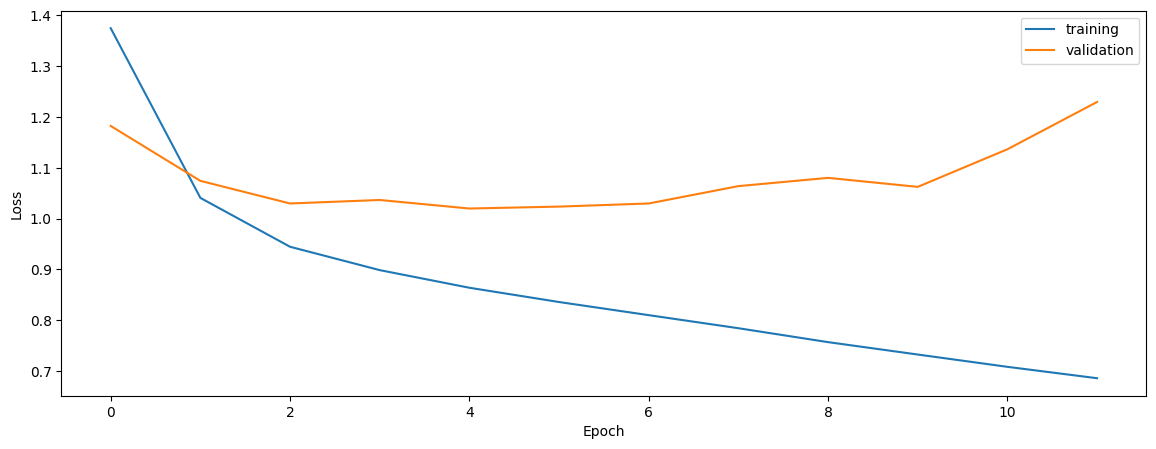

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6762557008170643
0.6100907947556122
0.6197296545005393


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.609097269754354
0.5970982142857143
0.5543715370184547


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6095449729981137
0.5902739575310815
0.5637672920219822


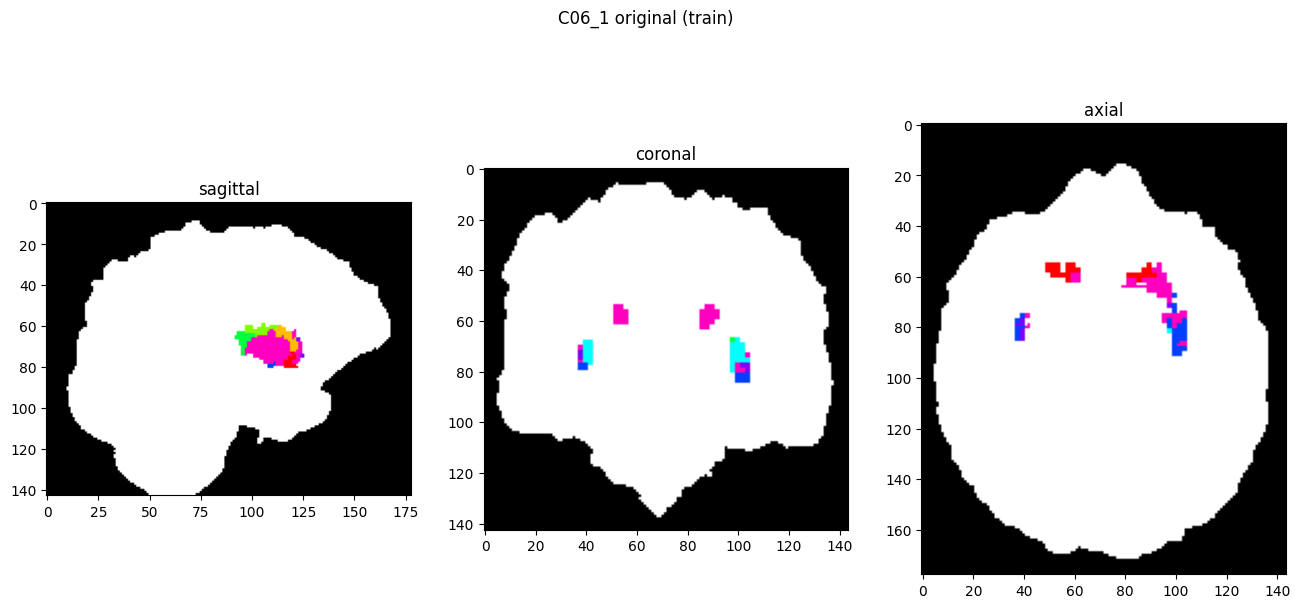

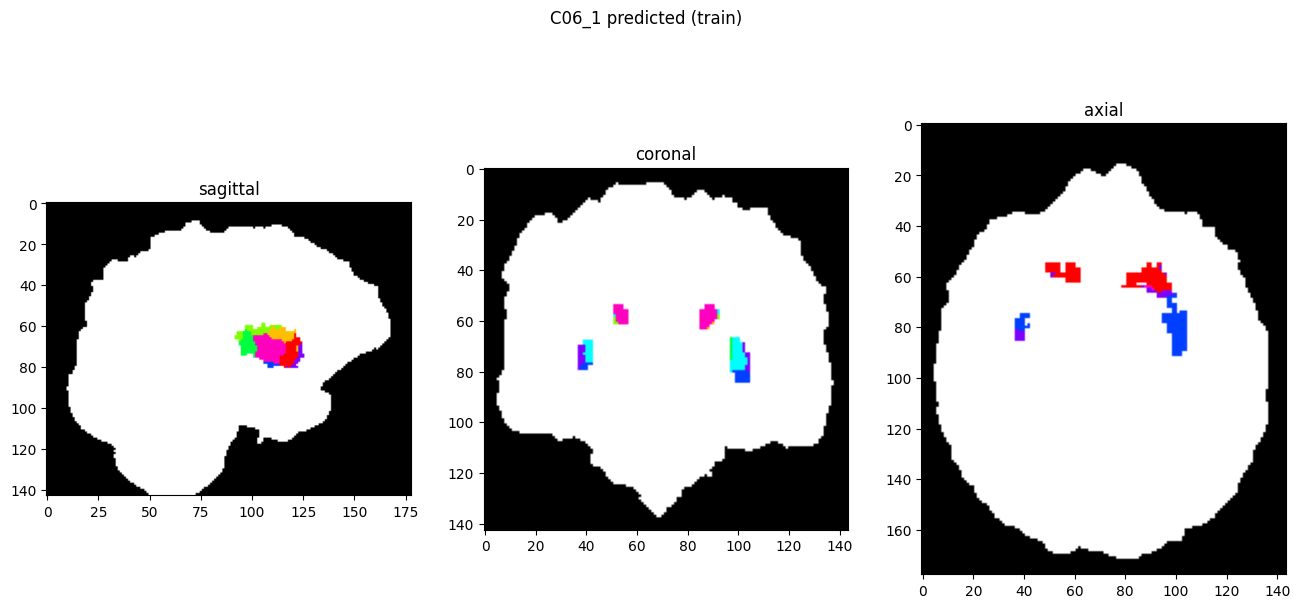

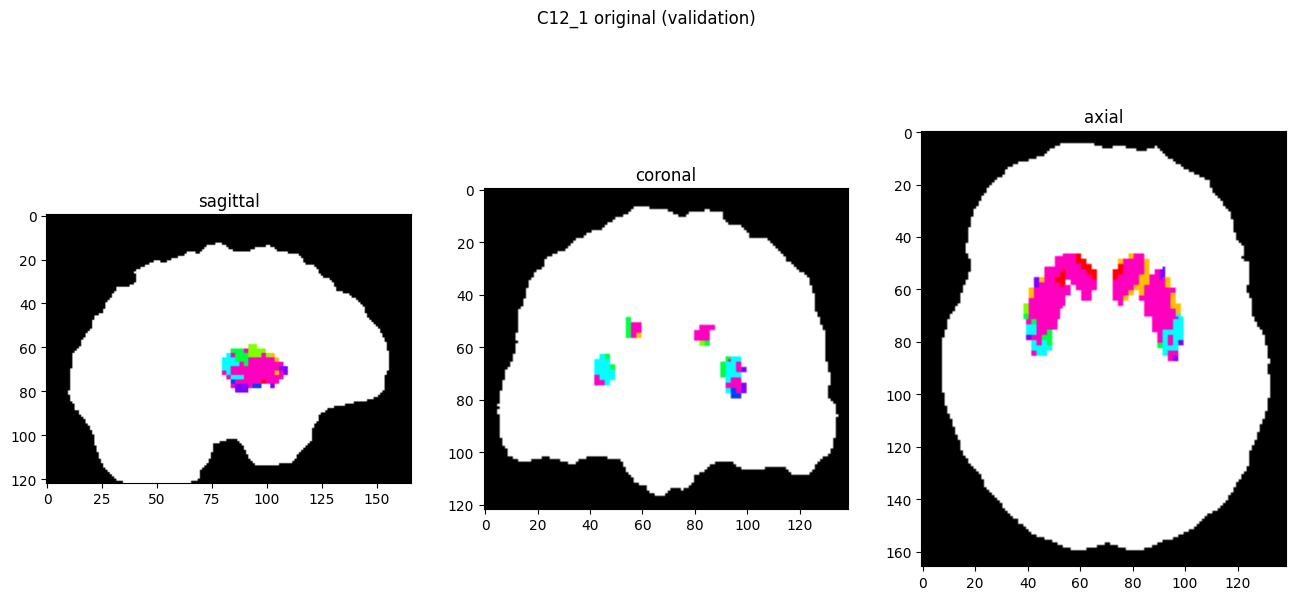

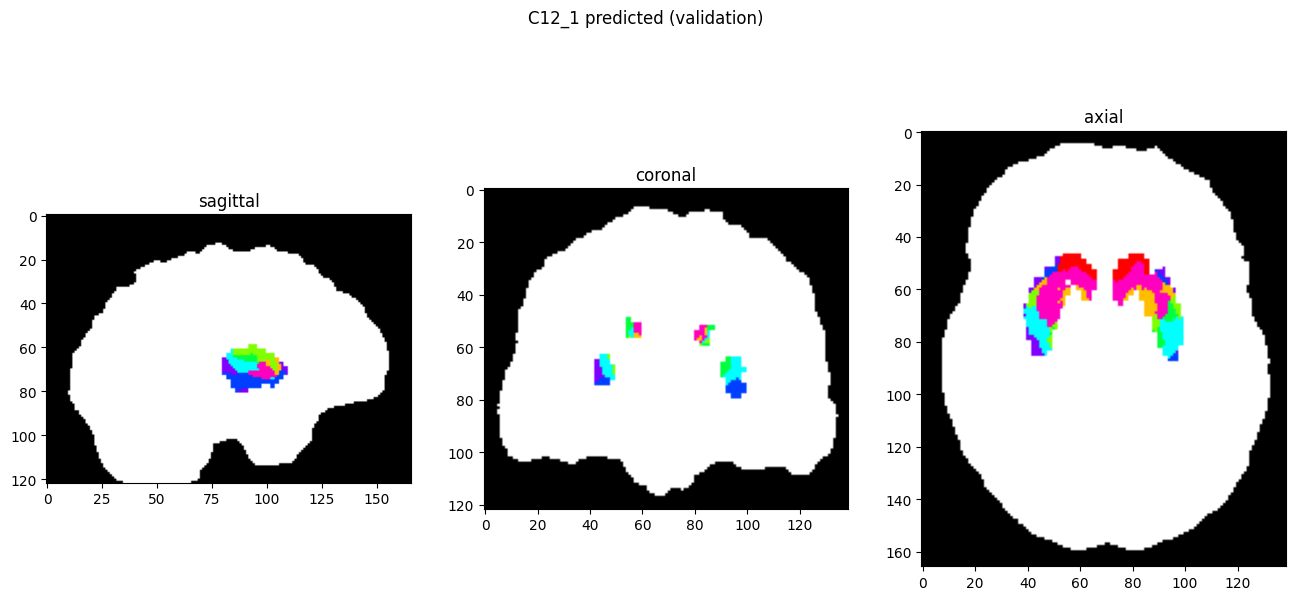

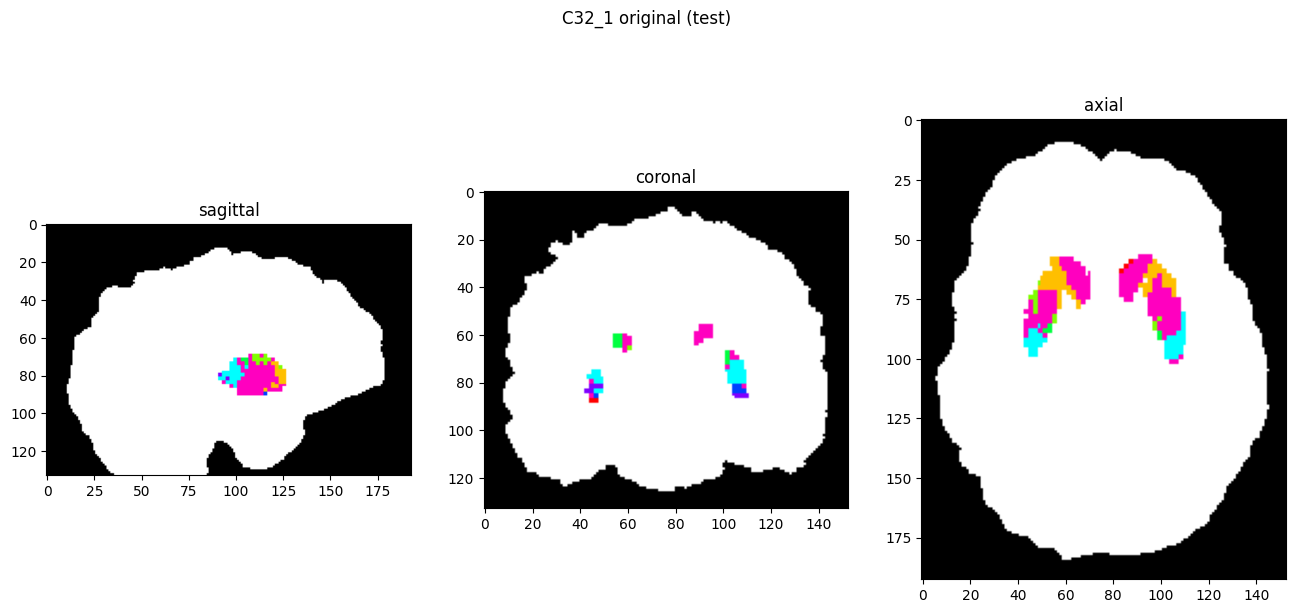

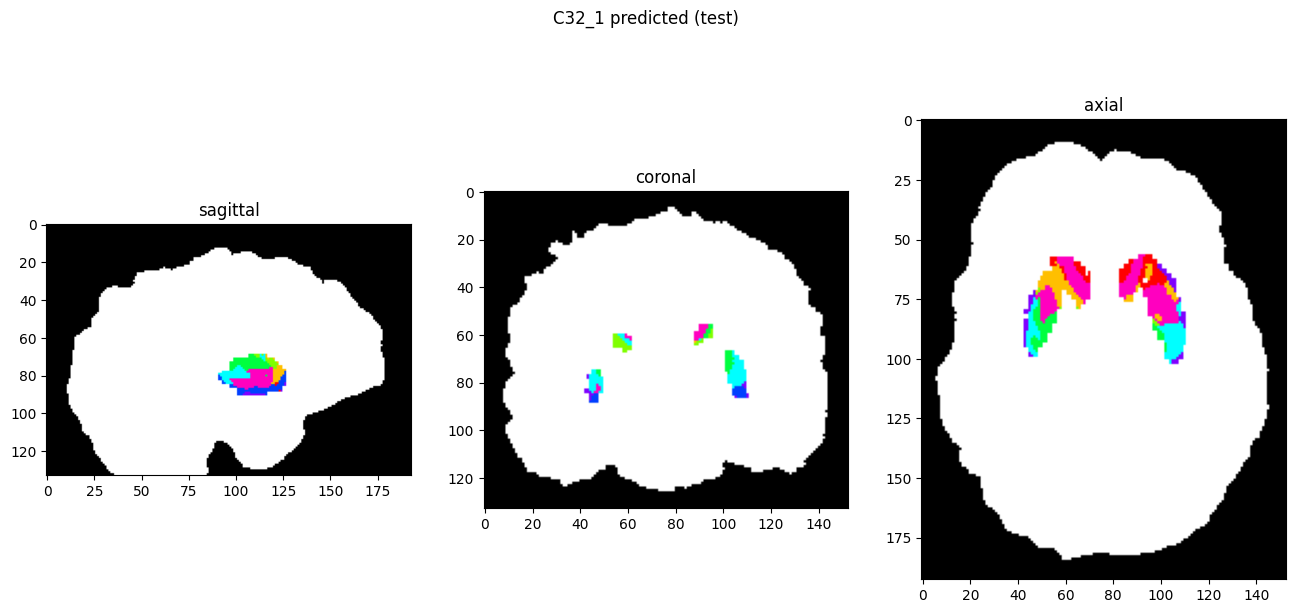

In [10]:
showResults(model, gen, threshold=0)